In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from logger import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common_functions import NPCL, common
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize'] = (20, 5)
npcl_obj = NPCL()
common_obj  = common()

In [3]:
import os
from logger import logger
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class testing:
    
    def add_lags(self, dff, target_col, large_data= False):
        try:
            # target_map = dff['consumed_unit'].to_dict()
            target_map = dff[target_col].to_dict()

            # 1 Hour, 2 Hours, 6 Hours
            dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
            dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
            dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
            # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
            # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
            dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
            # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
            # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
            # dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

            # if large_data:
            # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
            # dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
            # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
                # logger.info(f" lags added for large data")
            #     return dff
            # else:
            


            # logger.info(f"lags added")
            return dff
        
        except KeyError as e:
            logger.error(f"Error: {e}. 'consumed_unit' column not found in the DataFrame.",exc_info=True)
        except Exception as ex:
            logger.error(f"An unexpected error occurred: {ex}",exc_info= True)


    def create_features(self,hourly_data,lagre_data= False):
        try:
            hourly_data = hourly_data.copy()
            # Check if the index is in datetime format
            if not isinstance(hourly_data.index, pd.DatetimeIndex):
                hourly_data.index = pd.to_datetime(hourly_data.index)
            
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['day'] = hourly_data.index.day
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            # hourly_data['dayofyear'] = hourly_data.index.dayofyear
            # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
            # hourly_data['holiday'] = 0
            # if lagre_data:
            # hourly_data['month'] = hourly_data.index.month
            # hourly_data['quarter'] = hourly_data.index.quarter
            # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            # hourly_data['year'] = hourly_data.index.year
        
            return hourly_data

        except Exception as e:
            logger.info(f"error in feature creation: {e}",exc_info= True)

    def scaling_layer(self,dataset,target_variable= "Load_kW"):
        try:
            scaler = MinMaxScaler()
            # Exclude the "Load_kW" column from features to normalize
            features_to_normalize = [col for col in dataset.columns if col != target_variable]
        
            dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
            with open('saved_model/minmax_scaler_all_feeders.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            return dataset
        
        except Exception as e:
            logger.error(f"error in scaling: {e}",exc_info= True) 

    def data_split_function(self,dataset, target_variable= "Load_kW"):
        """
            Splits the given dataset into training and testing sets, separating features and the target variable.

            Args:
                dataset (pandas.DataFrame): The dataset containing both features and the target variable.
                target_variable (str): The name of the column representing the target variable to be predicted. Default is 'Load_kW'.

            Returns:
                X_train (pandas.DataFrame): Training set features.
                X_test (pandas.DataFrame): Testing set features.
                y_train (pandas.Series): Training set target variable.
                y_test (pandas.Series): Testing set target variable.
            
            Raises:
                Exception: If there's an issue during the data split, an error message is logged.

            Example:
                >>> df = pd.DataFrame({...})
                >>> X_train, X_test, y_train, y_test = obj.data_split(df, target_variable="Load_kW")
        """
        try:
            n = len(dataset)
            train_df = dataset[0:int(n*0.9)]
            test_df = dataset[int(n*0.9):]
            train_dataset, test_dataset = train_df.copy(),test_df.copy() #,val_df.copy()
            # train_labels = train_features.pop(target_variable)
            # test_labels = test_features.pop(target_variable)
            
            # print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            # print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"data split done")
            # logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            # logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"train_features shape:{train_dataset.shape}")
            logger.info(f"test_features shape:{test_dataset.shape}")

            return train_dataset,test_dataset
            # return train_features,test_features,train_labels, test_labels
        
        except Exception as e:
            logger.error(f"error in split: {e}",exc_info=True)


    def model_trainer(self, train_dataset, target_variable, random_state=True, model_name=None):
        try:
            # noramlizing data
            dataset_scalled = self.scaling_layer(dataset=train_dataset)

            # Split the dataset into training and test sets using train test split function with randomizing data
            if random_state:            
                # dataset_labels = dataset_scalled.pop(target_variable)
                train_features, test_features, train_label, test_label = self.data_split(dataset_scalled)    
            
            else:    
                # Split the dataset into training and test sets using custom data split function without randomizing data
                train_features, test_features = self.data_split_function(dataset=dataset_scalled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)
            
            os.makedirs('saved_model/test', exist_ok=True)
            if model_name == "RFR":
                # Step 4: Initialize the RandomForestRegressor model
                model= self.random_forest_regressor(train_features=train_features,
                                                    train_label=train_label)
                logger.info(f"model trained : RandomForestRegressor")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                
                # Save the model to a file
                # joblib.dump(model, 'saved_model/RandomForestRegressor_model.pkl'


            if model_name == "XGboost":
                model = self.XGboost_model(train_features= train_features,
                                        train_label= train_label)
                logger.info(f"model trained : XGboost")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                # Save the model to a file
                # joblib.dump(model, 'saved_model/XGboost_model.pkl')            
                        
            files = os.listdir("saved_model/test")
            if len(files) == 0:
                model_version = 1  # Start at version 1 if no files are present
            else:
                model_version = max([int(i.split(".")[1]) for i in files if i.split(".")[1].isdigit()]) + 1
            joblib.dump(model, f"saved_model/test/{model_name}.{model_version}.pkl")
            # model_version=max([int(i) for i in range(len(os.listdir("saved_model/test")+ [0])) ])+1
            # model.save(f"saved_model/test/{model_name}_1.{model_version}")
            return model
        except Exception as e:
            logger.error(f"error in model trainer: {e}",exc_info=True)

    def data_split(self, dataset, target_variable= "Load_kW"): 
        try:
            dataset_features = dataset.copy()
            dataset_label = dataset_features.pop(target_variable)
            # Split the dataset into training and test sets
            train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, random_state=42)
            logger.info(f"data split done")
            logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            return train_features, test_features, train_labels, test_labels

        except Exception as e:
            logger.error(f"error in data split: {e}",exc_info=True)  

    def random_forest_regressor(self, train_features, train_label):
        try:
            # model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tweak hyperparameters
            # model.fit(train_features,train_label)
            param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [10, 20, 30, 50, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'n_jobs': [-1]  # Use all cores for faster training
            }

            # Initialize the RandomForestRegressor model
            model = RandomForestRegressor(random_state=42)

            # Perform hyperparameter tuning using RandomizedSearchCV
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                            n_iter=10, cv=5, verbose=2, 
                                            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
            
            # Fit the RandomizedSearchCV to the data
            random_search.fit(train_features, train_label)
            
            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")
            
            # Train the model with the best parameters
            best_model = RandomForestRegressor(**best_params, random_state=42)
            best_model.fit(train_features, train_label)
            
            logger.info(f"Model trained: RandomForestRegressor with best parameters")
        
            return best_model
        
        except Exception as e:
            logger.error(f"error in random_forest_regressor: {e}", exc_info= True)
    def XGboost_model(self,train_features, train_label):
        try:
            xgb_model = XGBRegressor()
            xgb_model.fit(train_features, train_label)
            
            # Calculate and print model evaluation metrics for this sensor
            train_score = xgb_model.score(train_features, train_label)
            print(f"Initial Train Score {train_score}")
            
            # Perform hyperparameter tuning using RandomizedSearchCV
            param_grid = {
                    "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
                    "max_depth": [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
                    "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
                    "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "n_estimators": [200, 250, 300, 350,400, 450, 500],
                    # "max_depth": [3,5,10,15, 20, 25,30],
                    # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    }
            
            random_search = RandomizedSearchCV(xgb_model,
                                                param_distributions=param_grid,
                                                n_iter=5,
                                                scoring='neg_mean_squared_error',
                                                cv=5,
                                                random_state=100)

            # Fit the RandomizedSearchCV to the data
            # random_search.fit(X_train, y_train)
            random_search.fit(train_features, train_label)

            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")

            # Train the model with the best parameters
            best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            subsample=best_params['subsample'],
                                            colsample_bytree=best_params['colsample_bytree'],
                                            reg_alpha=best_params['reg_alpha'],
                                            base_score=0.5,
                                            booster='gbtree',
                                            # reg_lambda=best_params['reg_lambda'],
                                            objective='reg:squarederror')
            best_xgb_model.fit(train_features, train_label)

            # Evaluate the model on the test set
            test_score = best_xgb_model.score(train_features, train_label)
            print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
            return best_xgb_model
        except Exception as e:
            logger.info(f"error in XGboost: {e}",exc_info= True)


    def prediction(self,model, input_data, scoring=False, test_data= None,prediction= False):
        try:
            if prediction:
                scaler= self.scaler_value()

                input_data = scaler.transform(input_data)

            # Step 6: Make predictions
            y_pred = model.predict(input_data)
            if y_pred is not None:
                logger.info("predition_succesful")

            if scoring :
                # Step 7: Evaluate the model
                rmse = sqrt(mean_squared_error(test_data, y_pred))
                print("\nModel Power Evaluation")
                print("Mean Squared Error (MSE):", mean_squared_error(test_data, y_pred))
                print("Mean Absolute Error (MAE):", mean_absolute_error(test_data, y_pred))
                print(f"Root Mean Squared Error (RMSE): {rmse}")
                print("R-squared:", r2_score(test_data, y_pred))
                logger.info(f"\nModel Evaluation")
                logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
                logger.info(f"Mean Squared Error (MSE): {mean_squared_error(test_data, y_pred)}")
                logger.info(f"Mean Absolute Error (MAE): {mean_absolute_error(test_data, y_pred)}")
                logger.info(f"R-squared: {r2_score(test_data, y_pred)}")
            
                # Scatter plot
                plt.figure(figsize=(10, 6))
                # Plot actual values in red
                plt.plot(range(len(test_data)), test_data, color='red', label='Actual Power')
                # Plot predicted values in blue
                plt.plot(range(len(y_pred)), y_pred, color='blue', label='Predicted Power')
                # Adding labels and title
                plt.xlabel('Time')
                plt.ylabel('load')
                plt.title('Actual vs Predicted load')
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            return y_pred
        except Exception as e:
            logger.error(f"error in prediction: {e}",exc_info=True)


    def lstm_model_trainer(self, train_dataset, target_variable, random_state=True):
        try:
            # Scaling the data using MinMaxScaler
            dataset_scaled = self.scaling_layer(train_dataset)

            # Splitting the dataset
            if random_state:
                train_features, test_features, train_label, test_label = self.data_split(dataset_scaled)
            else:
                train_features, test_features = self.data_split_function(dataset_scaled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)

            # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
            train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
            test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))

            # Build LSTM model
            model = Sequential()

            # Adding LSTM layers
            model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
            model.add(Dropout(0.2))  # Prevent overfitting
            model.add(LSTM(units=64, return_sequences=False))
            model.add(Dropout(0.2))

            # Adding dense output layer
            model.add(Dense(units=1))  # Predicting the target variable

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = model.fit(train_features, train_label, epochs=20, batch_size=64, validation_data=(test_features, test_label))

            # Save the model to a file
            model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
            history.save(f"saved_model/test/lstm_model_{model_version}.h5")

            # Prediction and evaluation
            self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)

            return model

        except Exception as e:
            logger.error(f"Error in LSTM model trainer: {e}", exc_info=True)


In [4]:
df = npcl_obj.data_ingestion_npcl(data_path=os.getenv("data_path"))
data = npcl_obj.data_cleaning_and_validation(df)
# common_obj.correlation_matrix(df=data)

# data.set_index(['creation_time'],drop= True, inplace= True)

In [5]:
data.set_index('creation_time',drop=True,inplace=True)
# data.sort_values(['location_id','creation_time'],inplace=True)
# data.reset_index(drop=True,inplace=True)
zero_df = data[data['Load_kW']!=0]

threshold_value = 1
load_df = zero_df.groupby('location_id')[['Load_kW']].mean()
print(len(load_df[load_df['Load_kW']>threshold_value]))
location_lst = np.array(load_df[load_df['Load_kW']>threshold_value].index)
# print(location_lst)
# plt.scatter(range(len(load_df[load_df['Load_kW']>threshold_value])),load_df[load_df['Load_kW']>threshold_value])
df1 = data.loc[~data['location_id'].isin(location_lst)]
# df1.reset_index(inplace=True)
print(f"no of location_id : {df1['location_id'].nunique()}")


61
no of location_id : 279


In [34]:
grouped_df = df1.groupby("location_id")
testing_obj = testing()

latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912
from_date = df1.first_valid_index().date()
to_date = df1.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)
holidays_lst= common_obj.holidays_list(from_date,to_date)
# print("holidays_lst:",holidays_lst)

df_lst = []
for id , meter_df in grouped_df:
    resample_df = meter_df[['Load_kW']].resample(rule="1h").mean()
    if resample_df.isna().sum().sum() >0:
        continue
    if len(resample_df)<744:
        print(id)
    df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW")
    df_feature = testing_obj.create_features(df_lags)
    dff = df_feature.merge(weather_df,on=["creation_time"])
    dff['Load_kW']  = dff['Load_kW'].rolling(window=4).mean()
    dff['location_id'] = id
    df_lst.append(dff)
    

from_date:  2024-07-01 to_date:  2024-07-31
100000011201
100000031403


In [35]:
# grouped_df = df1.groupby("location_id")
# testing_obj = testing()

# latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912
# from_date = df1.first_valid_index().date()
# to_date = df1.last_valid_index().date()
# print("from_date: ",from_date,"to_date: ",to_date)
# weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)
# holidays_lst= common_obj.holidays_list(from_date,to_date)
# # print("holidays_lst:",holidays_lst)

# df_train_lst = []
# df_test_lst = []
# for id , meter_df in grouped_df:
#     resample_df = meter_df[['Load_kW']].resample(rule="1h").mean()
#     if resample_df.isna().sum().sum() >0:
#         continue
#     df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW")
#     df_feature = testing_obj.create_features(df_lags)
#     dff = df_feature.merge(weather_df,on=["creation_time"])
#     dff['location_id'] = id

#     n = len(dff)
#     train_dataset_each_feeder, test_dataset_each_feeder = dff[0:int(n*0.9)].copy(),dff[int(n*0.9):].copy()
#     print(f"train_dataset,test_dataset: {train_dataset_each_feeder.shape,test_dataset_each_feeder.shape}")

#     df_train_lst.append(train_dataset_each_feeder)
#     df_test_lst.append(test_dataset_each_feeder)
# print(len(df_train_lst))
# print(len(df_test_lst))

In [36]:
final_dff = pd.concat(df_lst)
# final_df.loc[final_df['Load_kW'].isna()].groupby('location_id').size().head(60)
# final_df[(final_df['location_id'] == 100000021704) & (final_df.isna().any(axis=1))]
# final_df.fillna(mean)
# Fill NaN values in each column with the mean of that column
print(f"null values : \n{final_dff.isna().sum()}")
final_dff.fillna(0, inplace=True)
# final_df = final_df.fillna(resample_df.mean())
print(f"location_id {final_dff['location_id'].nunique()}")
final_dff

null values : 
Load_kW                  651
lag1_hour                217
lag2_hours               434
lag3_hours               651
lag1_day                5208
hour                       0
day                        0
dayofweek                  0
apparent_temperature       0
rain                       0
wind_speed_10m             0
location_id                0
dtype: int64
location_id 217


,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,hour,day,dayofweek,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,30.4000,3.9000,9.8000,100000010001
2024-07-01 01:00:00,0.0000,0.0617,0.0000,0.0000,0.0000,1,1,0,34.9000,0.0000,2.3000,100000010001
2024-07-01 02:00:00,0.0000,0.0771,0.0617,0.0000,0.0000,2,1,0,35.0000,0.0000,6.4000,100000010001
2024-07-01 03:00:00,0.0568,0.0400,0.0771,0.0617,0.0000,3,1,0,35.7000,0.0000,8.4000,100000010001
2024-07-01 04:00:00,0.0522,0.0483,0.0400,0.0771,0.0000,4,1,0,37.1000,0.0000,8.2000,100000010001
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.8774,0.3550,1.5383,1.1214,0.5067,19,31,2,31.3000,25.1000,19.3000,100000190011
2024-07-31 20:00:00,0.6221,0.4950,0.3550,1.5383,0.3371,20,31,2,32.7000,15.3000,10.8000,100000190011
2024-07-31 21:00:00,0.2625,0.1000,0.4950,0.3550,0.1000,21,31,2,33.3000,6.0000,7.8000,100000190011


3720

217
160919


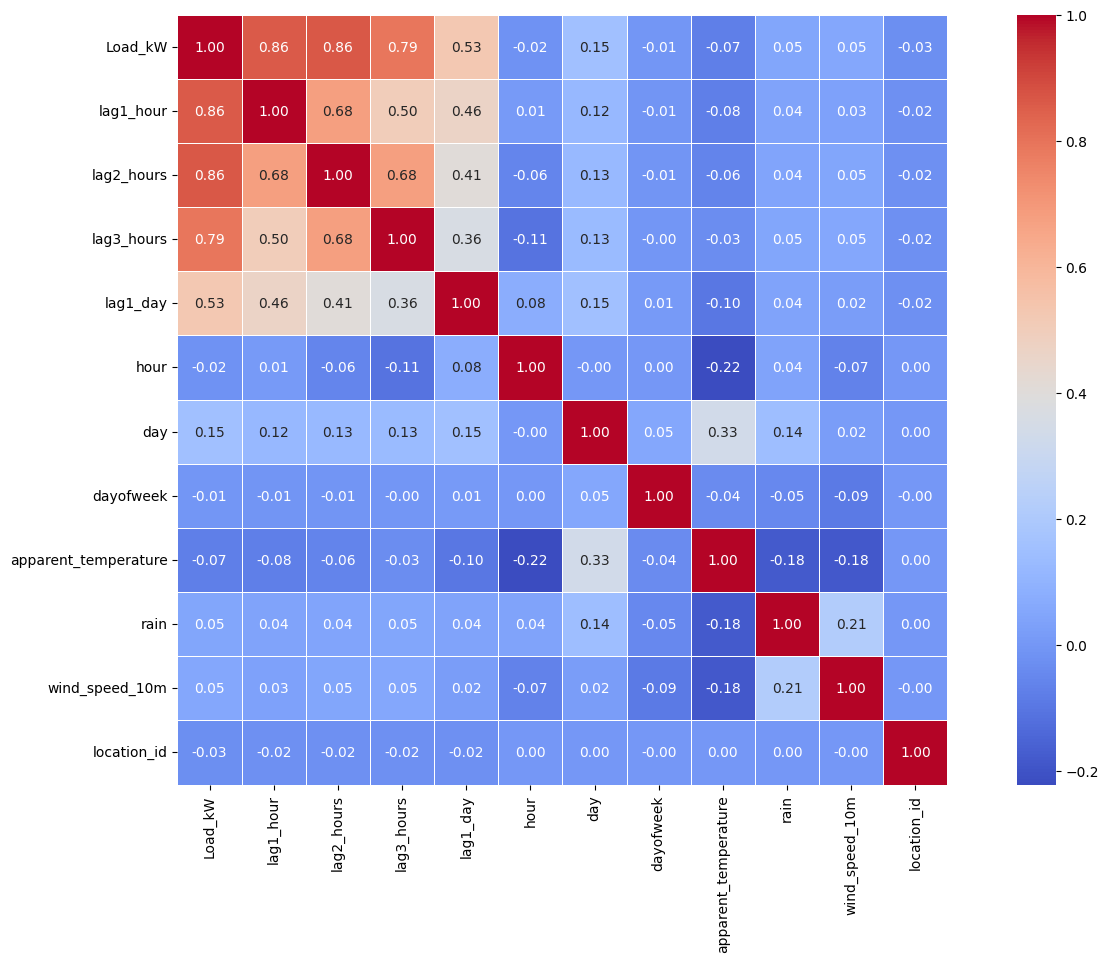

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,hour,day,dayofweek,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,,
2024-07-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,30.4000,3.9000,9.8000,100000010001
2024-07-01 01:00:00,0.0000,0.0617,0.0000,0.0000,0.0000,1,1,0,34.9000,0.0000,2.3000,100000010001
2024-07-01 02:00:00,0.0000,0.0771,0.0617,0.0000,0.0000,2,1,0,35.0000,0.0000,6.4000,100000010001
2024-07-01 03:00:00,0.0568,0.0400,0.0771,0.0617,0.0000,3,1,0,35.7000,0.0000,8.4000,100000010001
2024-07-01 04:00:00,0.0522,0.0483,0.0400,0.0771,0.0000,4,1,0,37.1000,0.0000,8.2000,100000010001
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.8774,0.3550,1.5383,1.1214,0.5067,19,31,2,31.3000,25.1000,19.3000,100000190011
2024-07-31 20:00:00,0.6221,0.4950,0.3550,1.5383,0.3371,20,31,2,32.7000,15.3000,10.8000,100000190011
2024-07-31 21:00:00,0.2625,0.1000,0.4950,0.3550,0.1000,21,31,2,33.3000,6.0000,7.8000,100000190011


In [66]:
# final_df.sort_values([['location_id','creation_time']],inplace=True)
# 60001
# final_df.reset_index(drop= True, inplace=True)
final_df = final_dff.iloc[:] #744*50
print(final_df['location_id'].nunique())
print(len(final_df))
common_obj.correlation_matrix(final_df)

final_df

In [67]:
final_df.sort_values(['creation_time'],inplace=True)
dff = final_df.copy()
n = len(dff)
train_dataset, test_dataset = dff[0:int(n*0.9)].copy(),dff[int(n*0.9):].copy()
print(f"train_dataset,test_dataset: {train_dataset.shape,test_dataset.shape}")

test_features = test_dataset.copy()
test_label = test_features.pop("Load_kW")
print(f"test_features,test_label: {test_features.shape,test_label.shape}")
print(test_dataset['location_id'].nunique())
print(train_dataset['location_id'].nunique())


train_dataset,test_dataset: ((144827, 12), (16092, 12))
test_features,test_label: ((16092, 11), (16092,))
215
217


In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

target_variable = ["Load_kW"]
# Exclude the "Load_kW" column from features to normalize
features_to_normalize = [col for col in train_dataset.columns if col not in target_variable]
# print(features_to_normalize)
feature_scaler = MinMaxScaler()
# feature_scaler = StandardScaler()
train_dataset[features_to_normalize] = feature_scaler.fit_transform(train_dataset[features_to_normalize])

# train_dataset ,test_dataset = final_df
n = len(train_dataset)
train_df, val_df = train_dataset[0:int(n*0.9)].copy(),train_dataset[int(n*0.9):].copy()
print(f"train_dataset,val_dataset: {train_df.shape,val_df.shape}")


# train 
train_features = train_df.copy()   
train_label = train_features.pop('Load_kW')
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

# val
val_features = val_df.copy()   
val_label = val_features.pop('Load_kW')
print(f"val_feature shape: {val_features.shape}\nval_label shape: {val_label.shape}")

train_dataset,val_dataset: ((130344, 12), (14483, 12))
train_features shape: (130344, 11)
train_label shape: (130344,)
val_feature shape: (14483, 11)
val_label shape: (14483,)


In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()


Initial Train Score 0.966500796071589
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 1, 'n_estimators': 650, 'max_depth': 30, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
TRAIN SCORE with hyperparameters tunning: 0.9724335249607655

Model Power Evaluation
Mean Absolute Error (MAE): 0.06308524844233053
Root Mean Squared Error (RMSE): 0.09893320558059318
R-squared: 0.9488007938906053


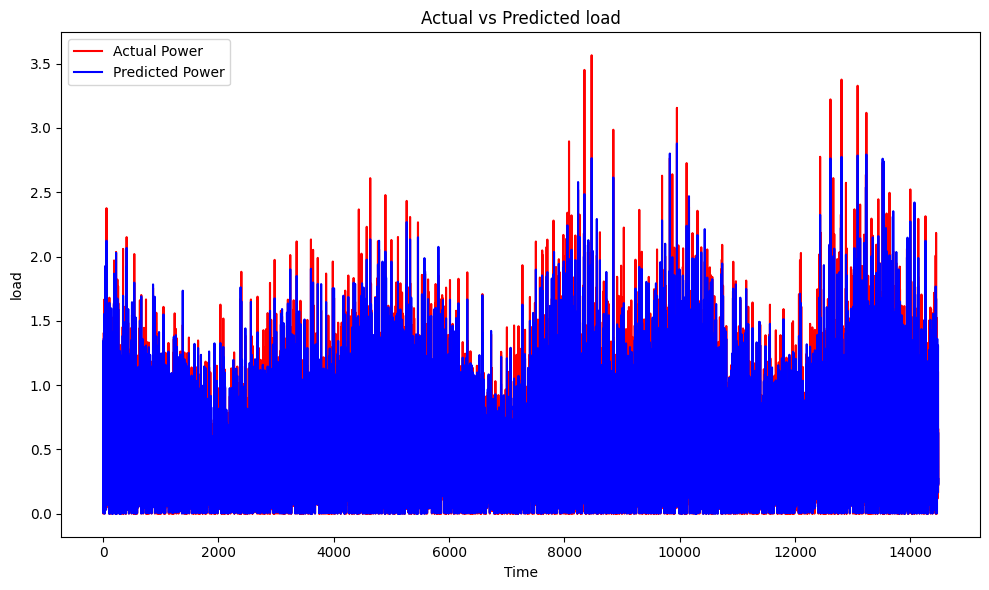


Model Power Evaluation
Mean Absolute Error (MAE): 0.08214319083212467
Root Mean Squared Error (RMSE): 0.12519473244484242
R-squared: 0.9421563124650335


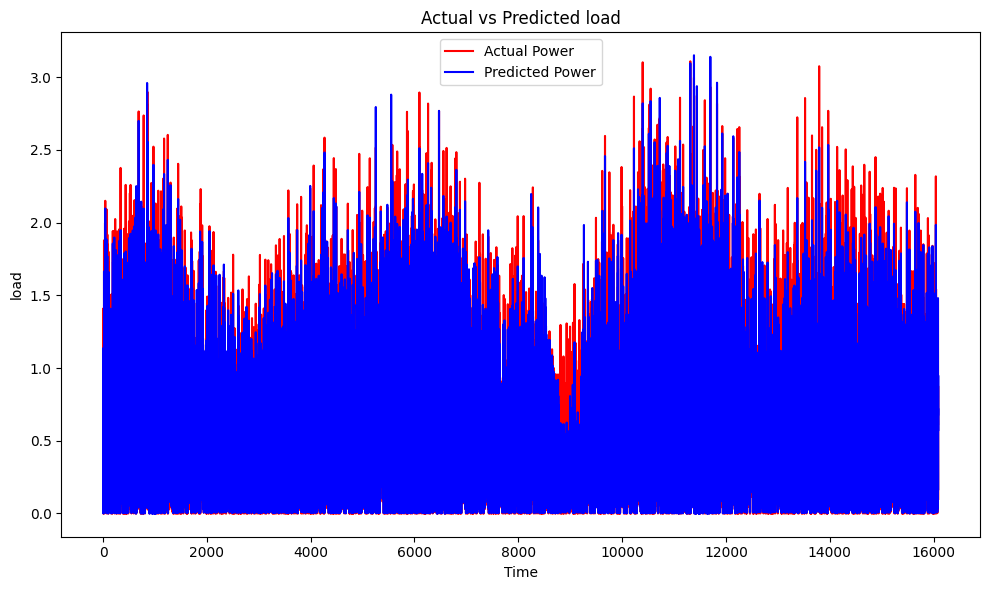

In [70]:
from sklearn.model_selection import TimeSeriesSplit

xgb_model = XGBRegressor()
xgb_model.fit(train_features, train_label)

# Calculate and print model evaluation metrics for this sensor
train_score = xgb_model.score(train_features, train_label)
print(f"Initial Train Score {train_score}")

# Perform hyperparameter tuning using RandomizedSearchCV
param_grid = {
        "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
        "max_depth": [ 10, 15, 20, 25, 30, 35, 40], # 1, 2, 3, 5,
        "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
        "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        'reg_lambda': [0.01, 0.1, 0.5, 1.0],  # Add L2 regularization

    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_depth': [3, 5, 7, 10],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.5, 0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'reg_alpha': [0.01, 0.1, 0.5, 1.0]

        # "n_estimators": [200, 250, 300, 350,400, 450, 500],
        # "max_depth": [3,5,10,15, 20, 25,30],
        # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        }

# random_search = RandomizedSearchCV(xgb_model,
#                                     param_distributions=param_grid,
#                                     n_iter=5,
#                                     scoring='neg_mean_squared_error',
#                                     cv=5,
#                                     random_state=100)

# # Fit the RandomizedSearchCV to the data
# # random_search.fit(X_train, y_train)
# random_search.fit(train_features, train_label)

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use time series split
    verbose=1,
    random_state=100
)

random_search.fit(train_features, train_label)


# Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                subsample=best_params['subsample'],
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_alpha=best_params['reg_alpha'],
                                base_score=0.5,
                                booster='gbtree',
                                # reg_lambda=best_params['reg_lambda'],
                                objective='reg:squarederror')
best_xgb_model.fit(train_features, train_label)

# Evaluate the model on the test set
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

best_xgb_model

plot_prediction(val_label,best_xgb_model.predict(val_features))
plot_prediction(test_label, best_xgb_model.predict(feature_scaler.transform(test_features)))


In [71]:
test_features['location_id'].unique()

array([100000010501, 100000021204, 100000030503, 100000021102,
       100000040601, 100000040902, 100000030704, 100000030601,
       100000021201, 100000040704, 100000030301, 100000021701,
       100000020906, 100000020201, 100000040303, 100000040304,
       100000020205, 100000030205, 100000020601, 100000031004,
       100000010306, 100000030806, 100000030101, 100000040301,
       100000031202, 100000031101, 100000041106, 100000020203,
       100000020404, 100000040805, 100000020606, 100000040405,
       100000040003, 100000030901, 100000031806, 100000010205,
       100000020403, 100000020003, 100000020306, 100000041402,
       100000020006, 100000031904, 100000031702, 100000011405,
       100000040104, 100000011401, 100000021802, 100000021103,
       100000021703, 100000040103, 100000031201, 100000020904,
       100000030102, 100000010502, 100000020303, 100000040705,
       100000031105, 100000030706, 100000020705, 100000020204,
       100000020104, 100000020406, 100000041205, 100000

In [100]:
for id in test_dataset['location_id'].unique():
    a = test_dataset[test_dataset['location_id']==id].copy()
    feeder_features = a.copy()
    feeder_label = feeder_features.pop("Load_kW")
    # print(feeder_features.shape,feeder_label.shape,feeder_features.columns)

    score = r2_score(feeder_label, best_xgb_model.predict(feature_scaler.transform(feeder_features)))
    if score <0.5 :
        print(id,score)


100000040902 0.0
100000030301 0.0
100000021701 0.32984897541415437
100000031004 0.36522869546585723
100000040301 -1.371926497255262
100000020203 0.0
100000040805 0.1208817257108008
100000021703 -10.109575328938774
100000021606 0.0
100000010001 -0.575541000615557
100000040202 0.0
100000040505 -0.882281495832484
100000030401 0.0
100000040905 0.3636323963344197
100000021003 -2.0194152786875788
100000021501 -16.906455788564774
100000010206 0.0
100000010004 -5.0026466490267305
100000031603 0.28700112745056117
100000040204 0.0
100000021806 0.0
100000031002 0.0
100000040703 -0.3007899490716319



Model Power Evaluation
Mean Absolute Error (MAE): 0.003331837924197316
Root Mean Squared Error (RMSE): 0.003684514658802588
R-squared: 0.0


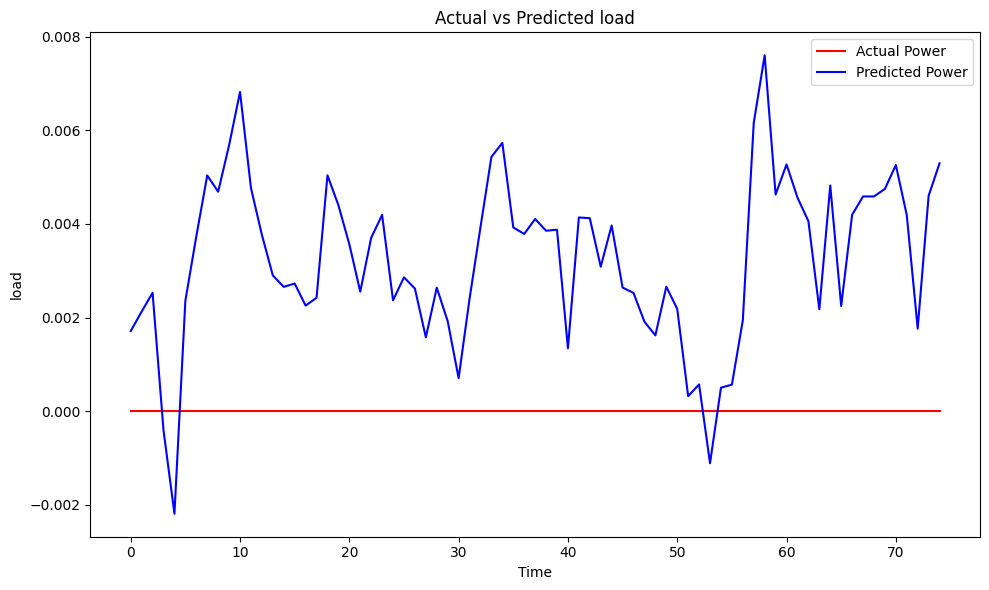


Model Power Evaluation
Mean Absolute Error (MAE): 0.0043021136751243225
Root Mean Squared Error (RMSE): 0.00491909864031018
R-squared: 0.0


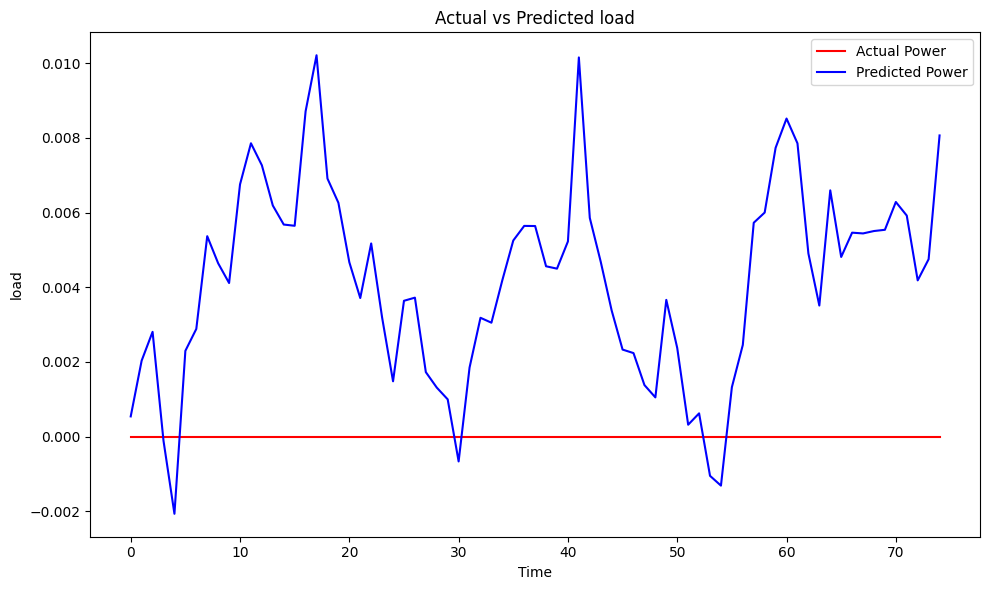


Model Power Evaluation
Mean Absolute Error (MAE): 0.024553171035687243
Root Mean Squared Error (RMSE): 0.029452585406266187
R-squared: 0.32984897541415437


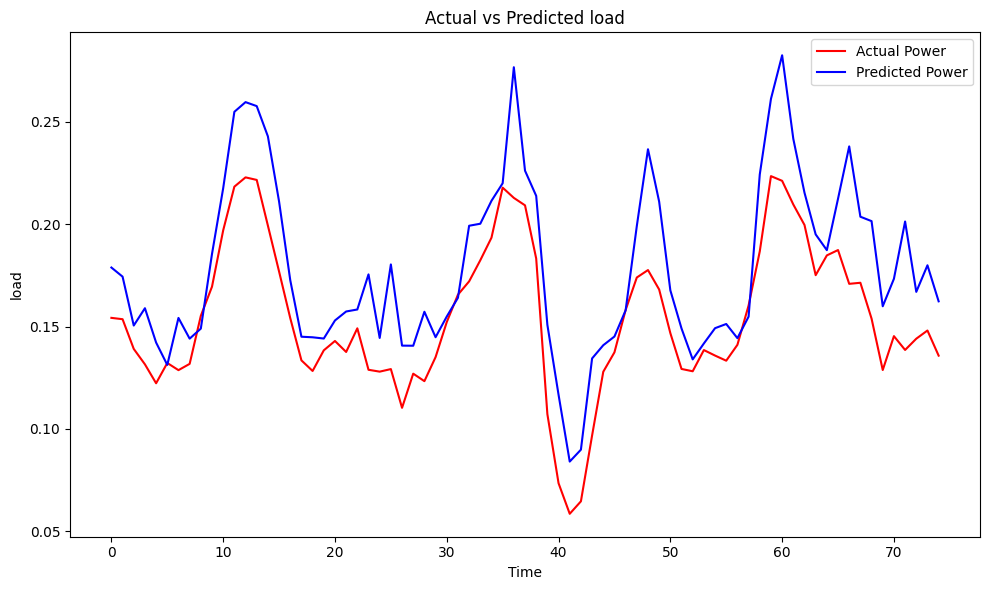


Model Power Evaluation
Mean Absolute Error (MAE): 0.2474189333429468
Root Mean Squared Error (RMSE): 0.29713312710192613
R-squared: 0.36522869546585723


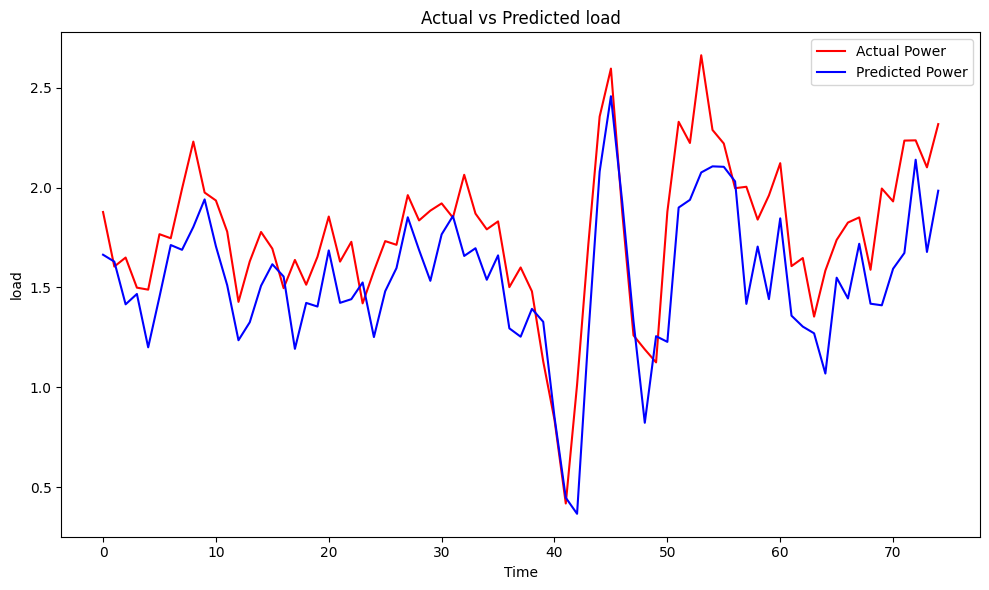


Model Power Evaluation
Mean Absolute Error (MAE): 0.00643521097377179
Root Mean Squared Error (RMSE): 0.008542639884965677
R-squared: -1.371926497255262


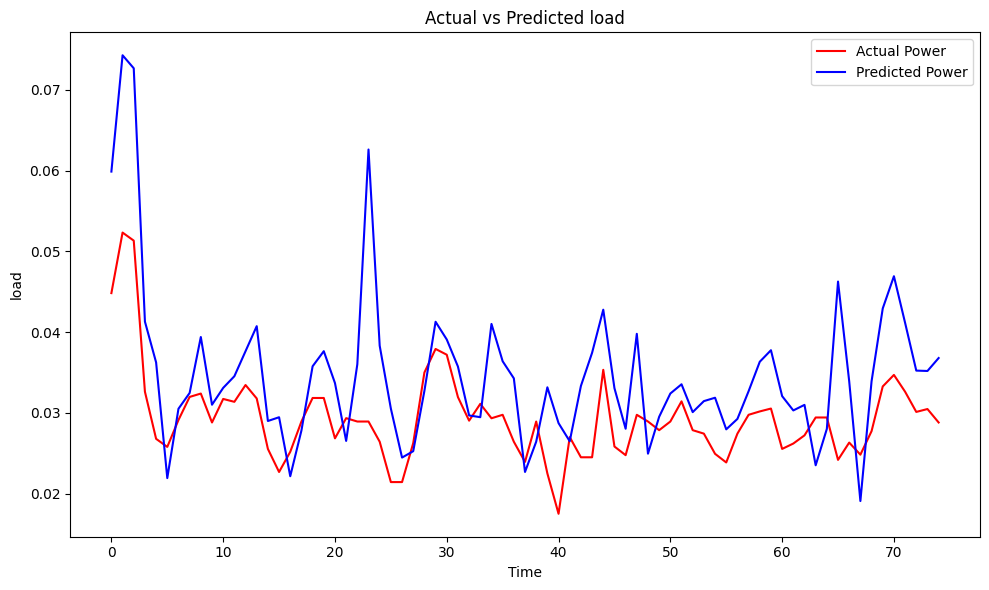


Model Power Evaluation
Mean Absolute Error (MAE): 0.005436493152519688
Root Mean Squared Error (RMSE): 0.006069757429663749
R-squared: 0.0


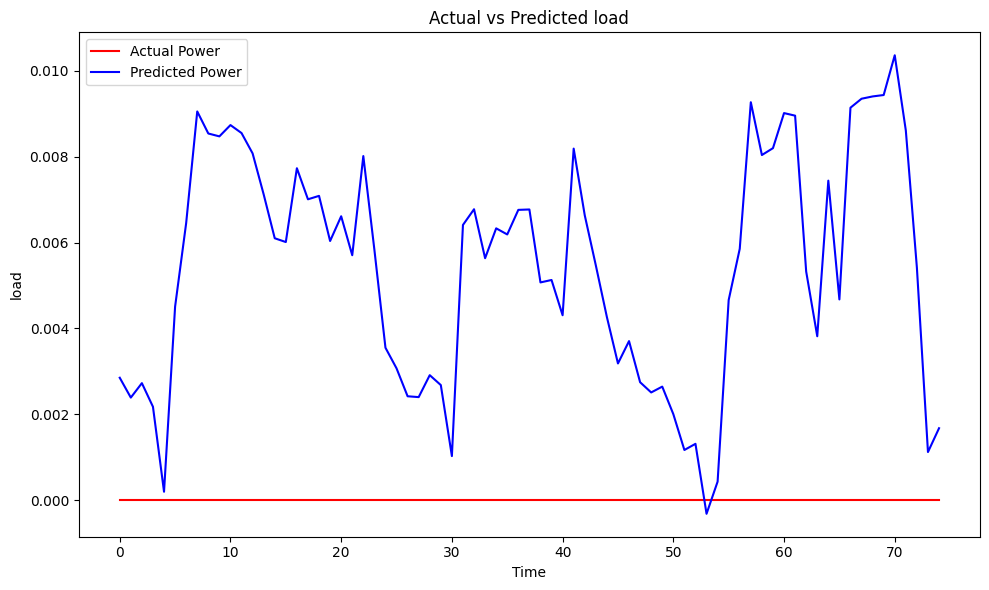


Model Power Evaluation
Mean Absolute Error (MAE): 0.00789079577928493
Root Mean Squared Error (RMSE): 0.010650249255472583
R-squared: 0.1208817257108008


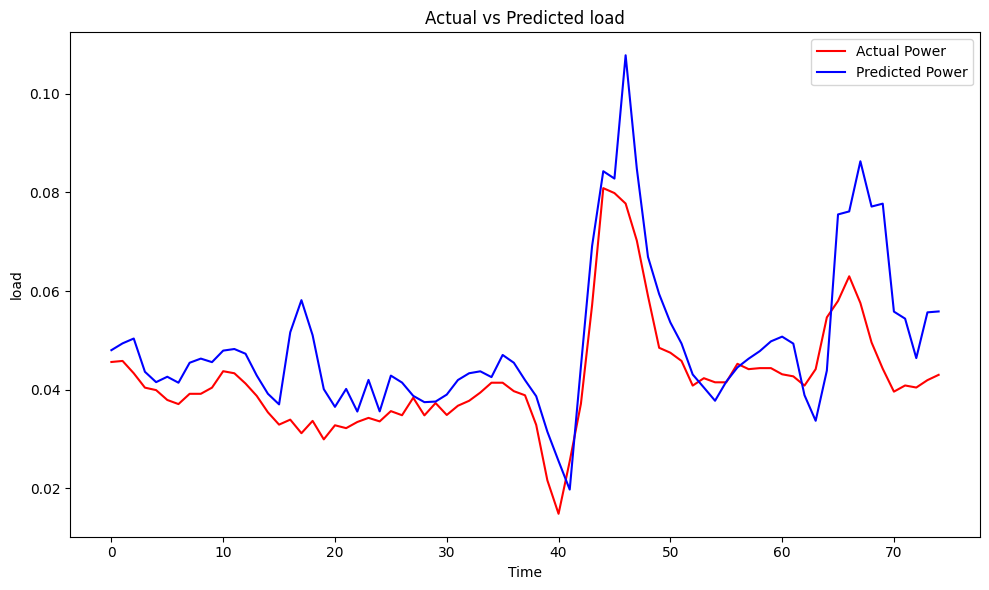


Model Power Evaluation
Mean Absolute Error (MAE): 0.008853368389737151
Root Mean Squared Error (RMSE): 0.014429591263821966
R-squared: -10.109575328938774


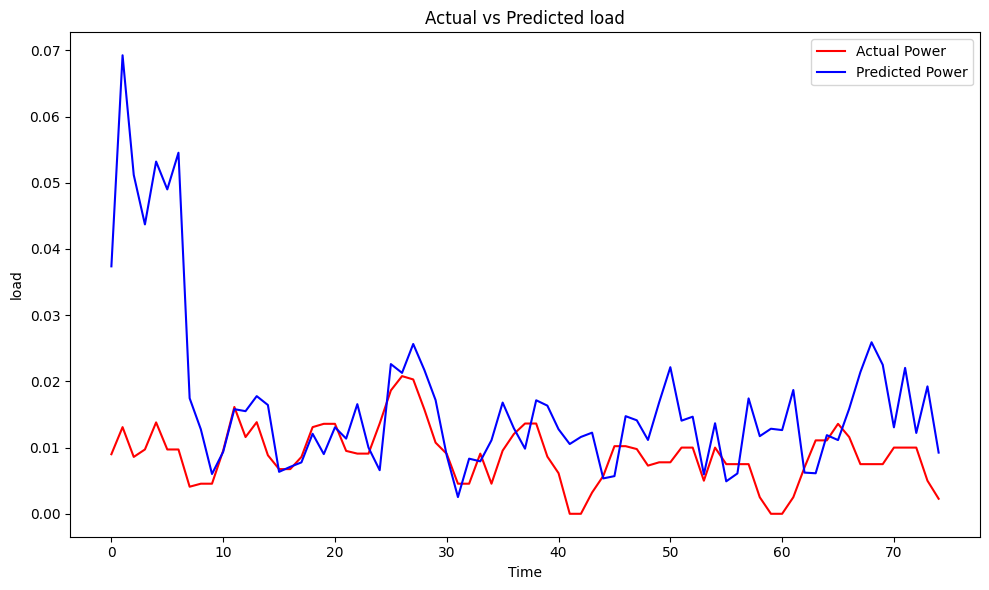


Model Power Evaluation
Mean Absolute Error (MAE): 0.005166740752368545
Root Mean Squared Error (RMSE): 0.00581814225968848
R-squared: 0.0


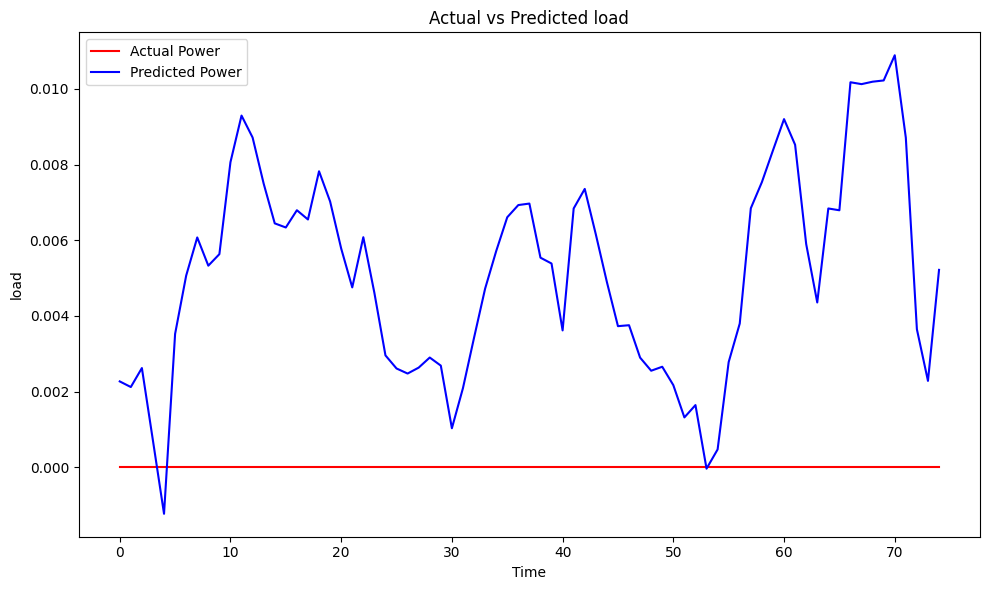


Model Power Evaluation
Mean Absolute Error (MAE): 0.014556970795922816
Root Mean Squared Error (RMSE): 0.02027160689451644
R-squared: -0.575541000615557


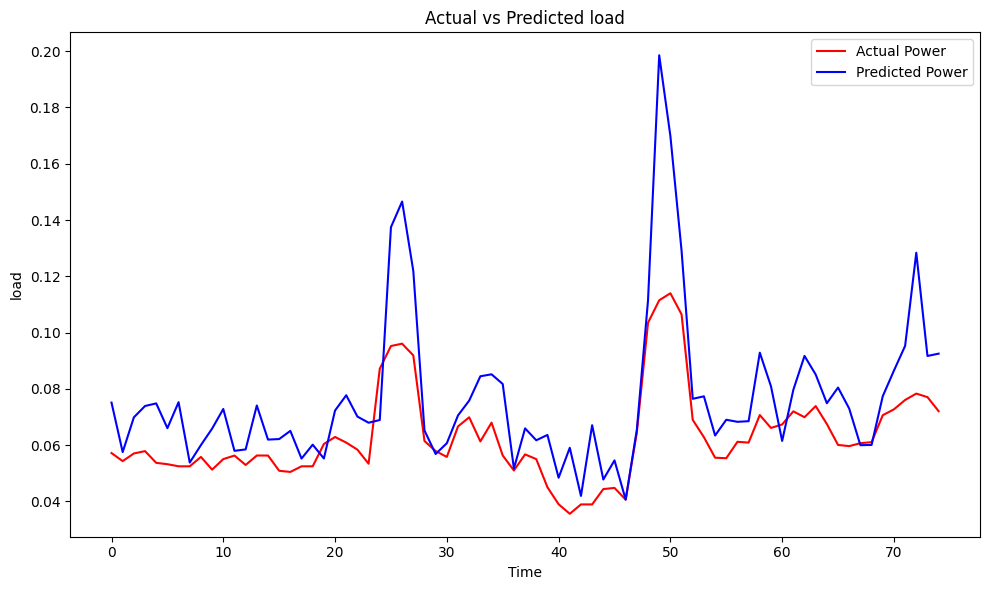


Model Power Evaluation
Mean Absolute Error (MAE): 0.004221217355225235
Root Mean Squared Error (RMSE): 0.004687704362073661
R-squared: 0.0


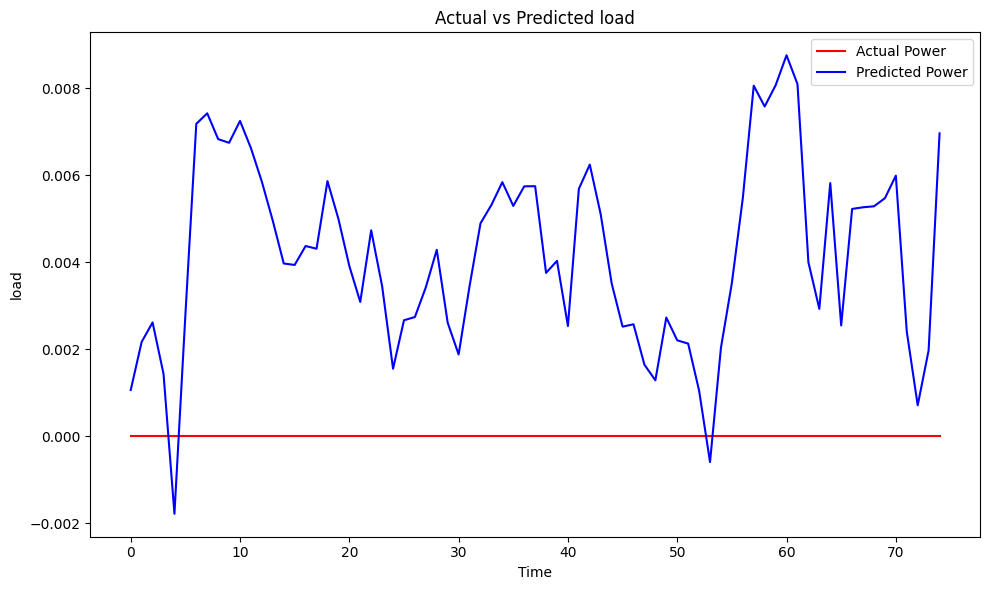


Model Power Evaluation
Mean Absolute Error (MAE): 0.03392196064718185
Root Mean Squared Error (RMSE): 0.04121917102295957
R-squared: -0.882281495832484


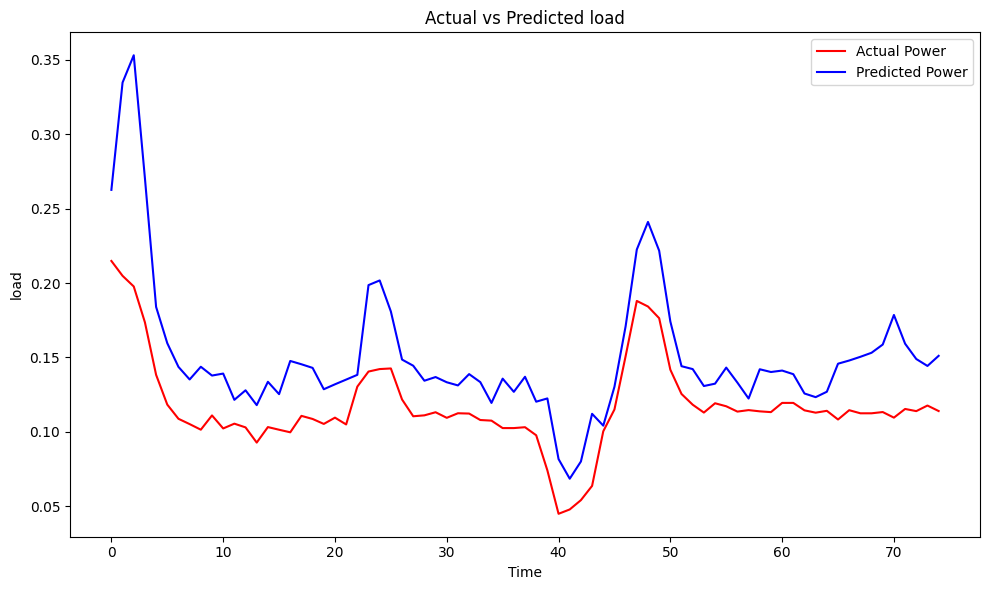


Model Power Evaluation
Mean Absolute Error (MAE): 0.0044894134404603395
Root Mean Squared Error (RMSE): 0.005099298829857529
R-squared: 0.0


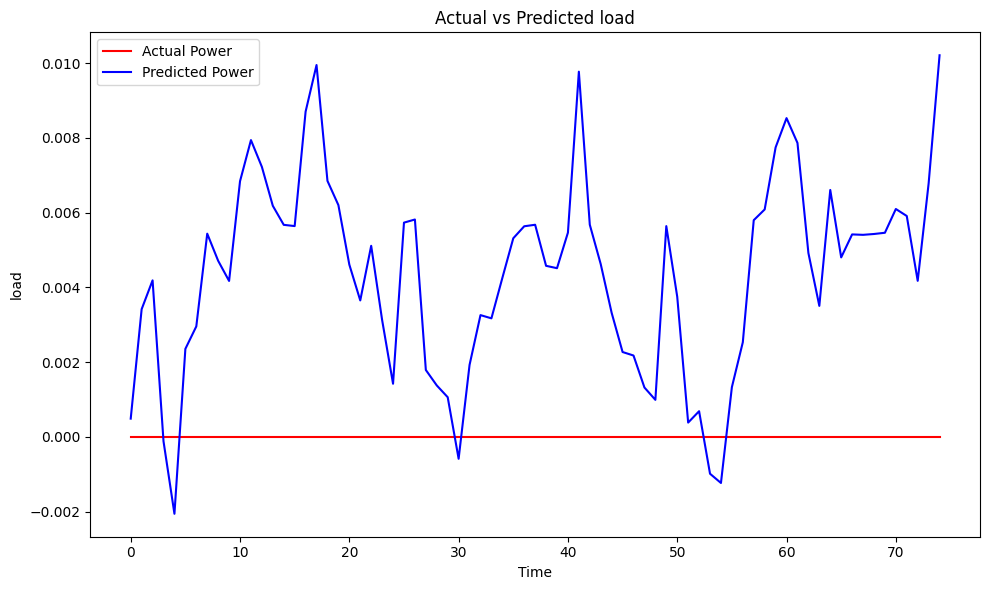


Model Power Evaluation
Mean Absolute Error (MAE): 0.02530192118992882
Root Mean Squared Error (RMSE): 0.032439148973884974
R-squared: 0.3636323963344197


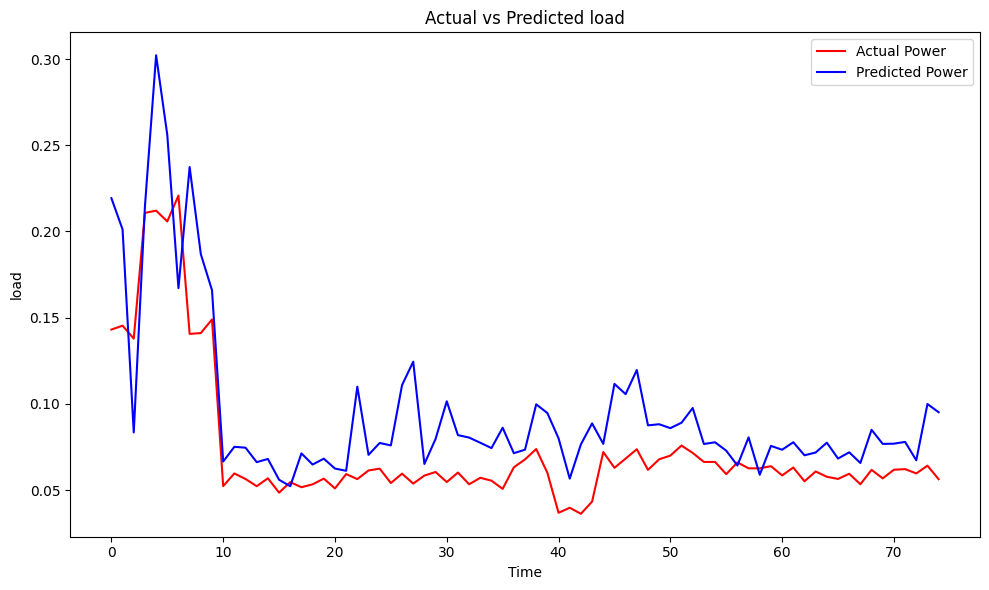


Model Power Evaluation
Mean Absolute Error (MAE): 0.018156228784405322
Root Mean Squared Error (RMSE): 0.019495051311322474
R-squared: -2.0194152786875788


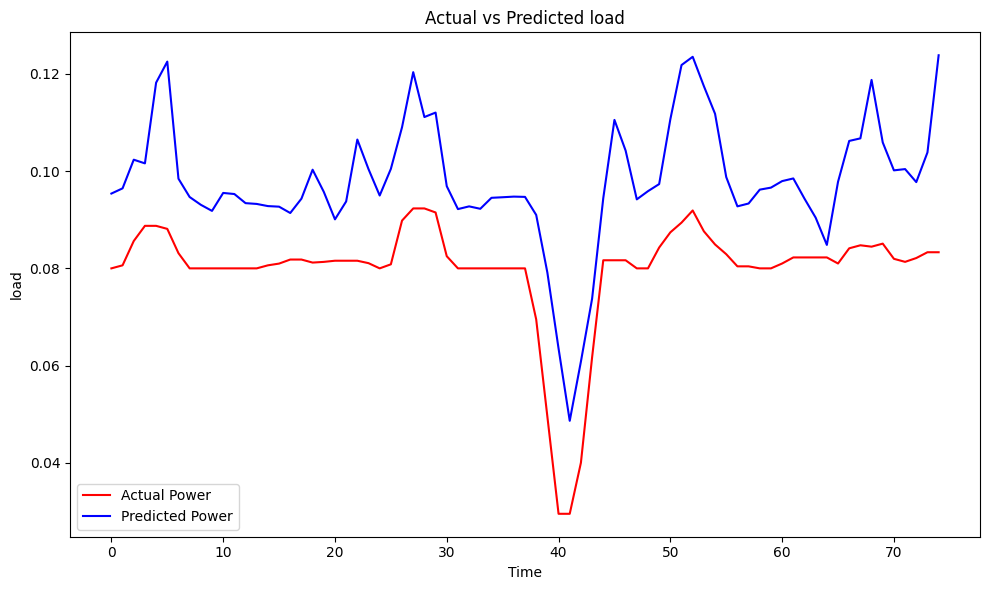


Model Power Evaluation
Mean Absolute Error (MAE): 0.015358236878312743
Root Mean Squared Error (RMSE): 0.021448655333888154
R-squared: -16.906455788564774


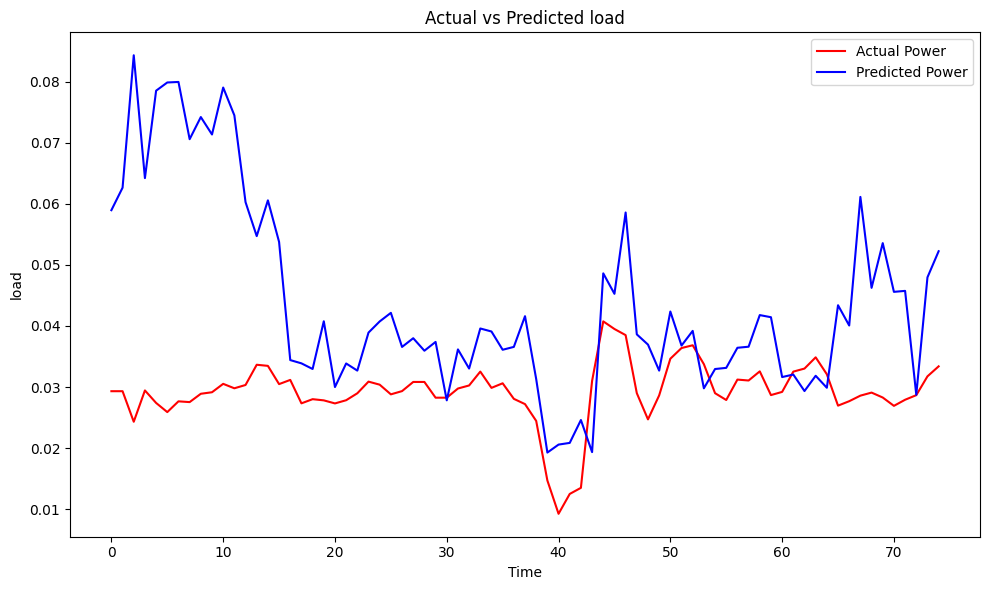


Model Power Evaluation
Mean Absolute Error (MAE): 0.0030664428018887216
Root Mean Squared Error (RMSE): 0.0034335032361676975
R-squared: 0.0


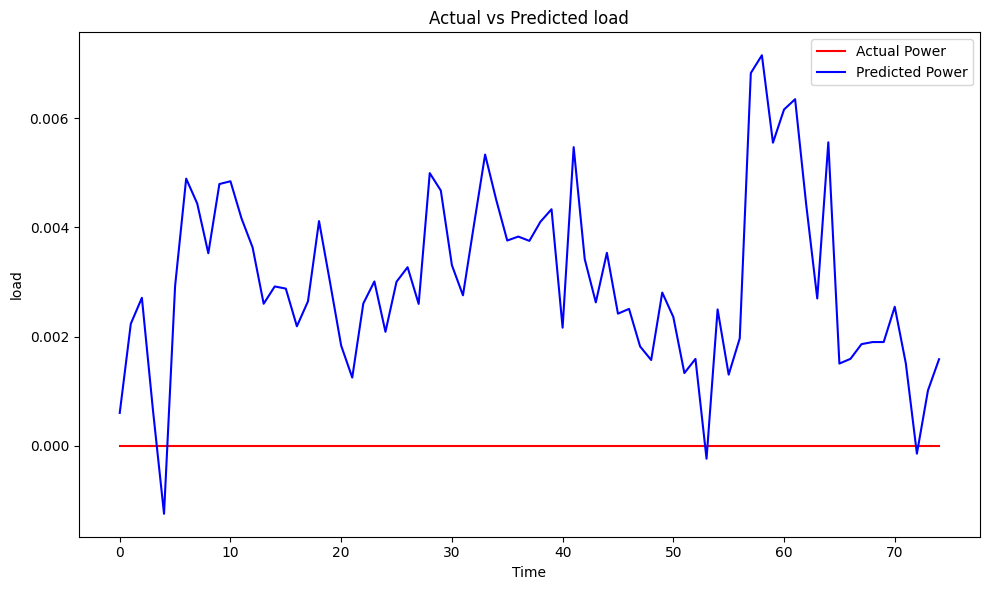


Model Power Evaluation
Mean Absolute Error (MAE): 0.004126505789756775
Root Mean Squared Error (RMSE): 0.004798104822759669
R-squared: -5.0026466490267305


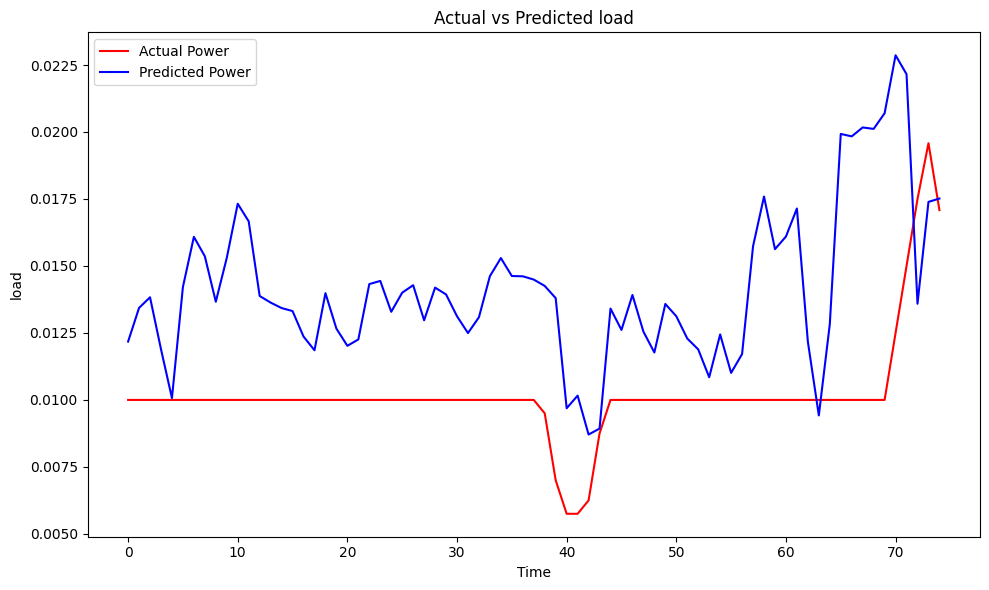


Model Power Evaluation
Mean Absolute Error (MAE): 0.01790996214614661
Root Mean Squared Error (RMSE): 0.021957215773460662
R-squared: 0.28700112745056117


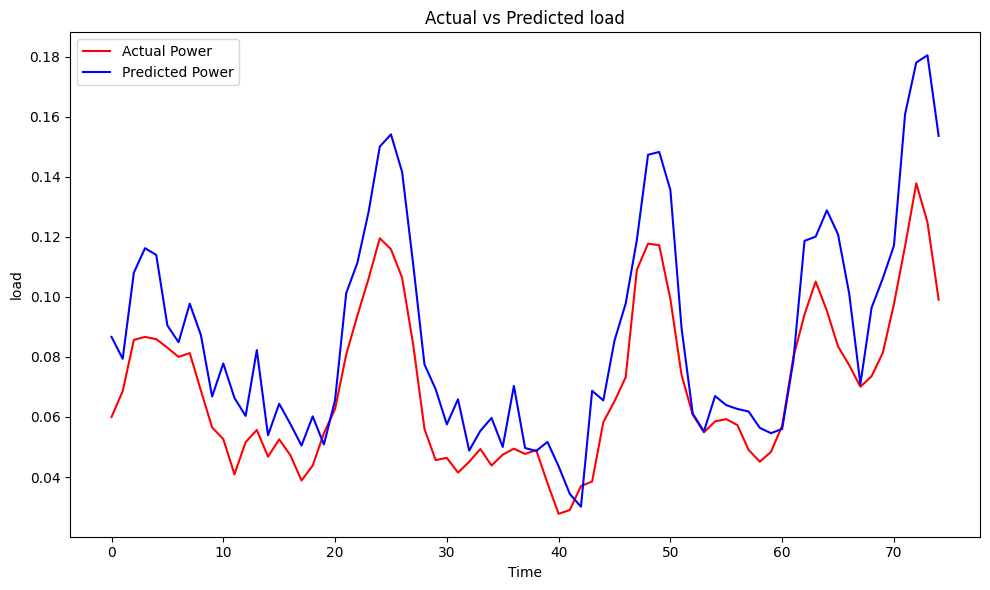


Model Power Evaluation
Mean Absolute Error (MAE): 0.0045910940614218515
Root Mean Squared Error (RMSE): 0.005045849993247508
R-squared: 0.0


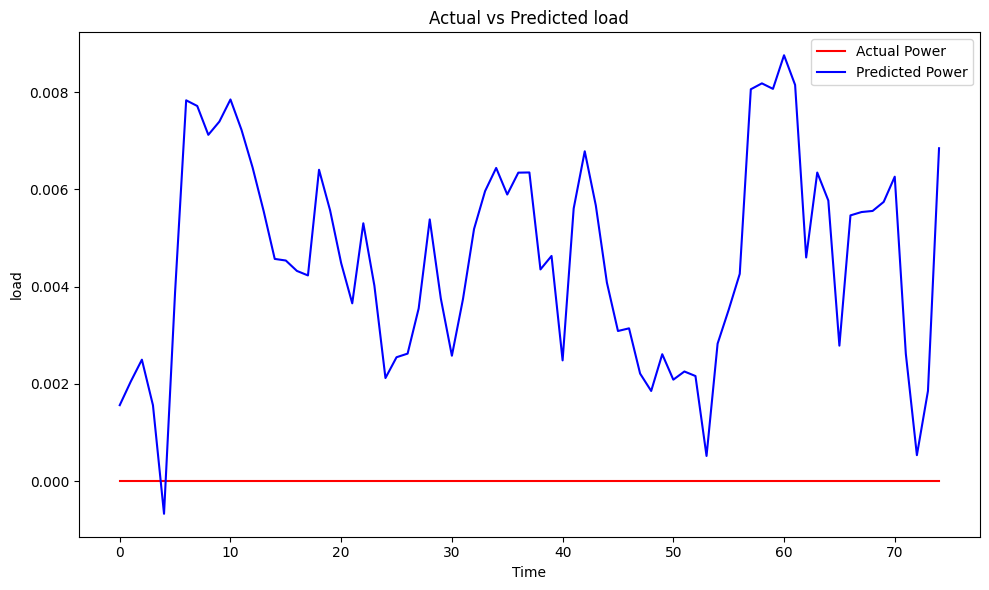


Model Power Evaluation
Mean Absolute Error (MAE): 0.004362020696135005
Root Mean Squared Error (RMSE): 0.004959791487284226
R-squared: 0.0


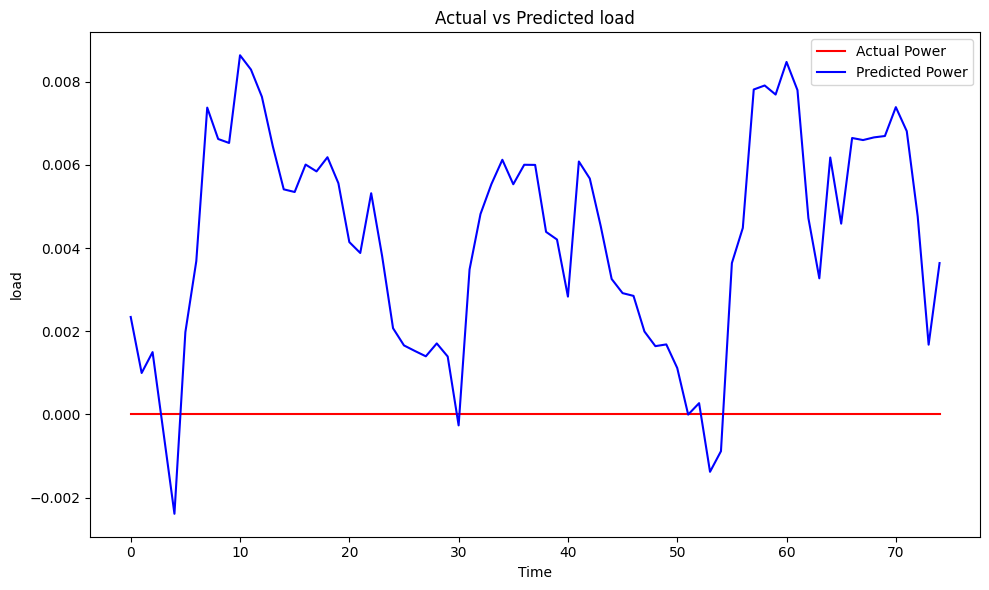


Model Power Evaluation
Mean Absolute Error (MAE): 0.006404652947723563
Root Mean Squared Error (RMSE): 0.006810484296649607
R-squared: 0.0


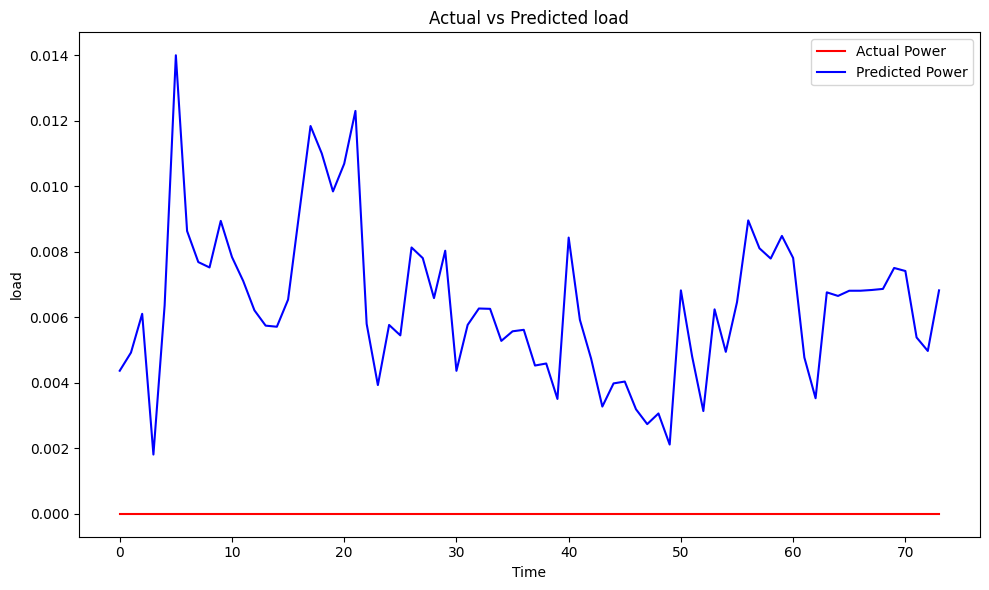


Model Power Evaluation
Mean Absolute Error (MAE): 0.006714904567698933
Root Mean Squared Error (RMSE): 0.00843024283306584
R-squared: -0.3007899490716319


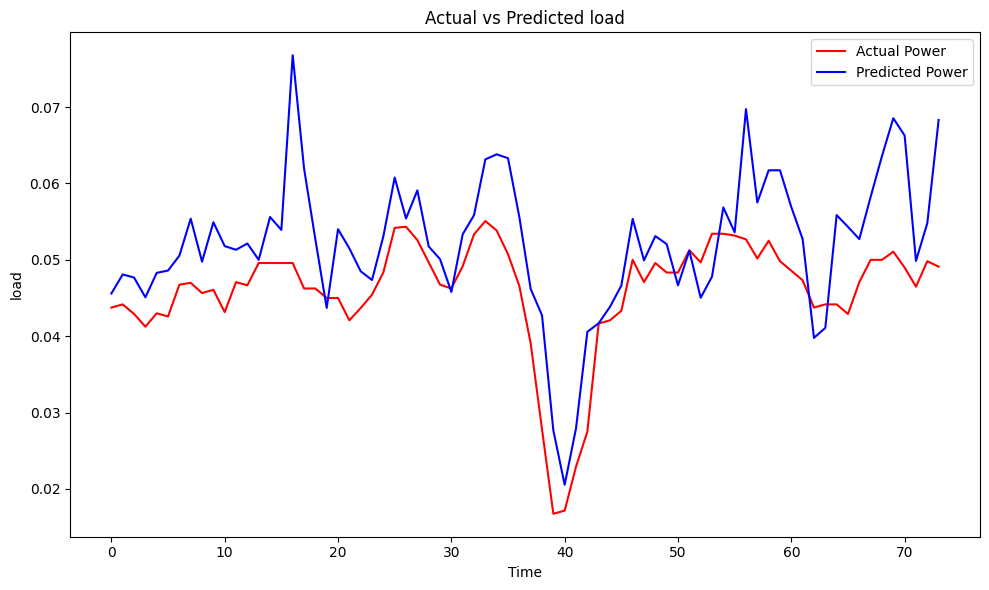

In [103]:
for id in [100000040902,100000030301 ,100000021701 ,100000031004 ,100000040301 ,100000020203 ,100000040805 ,100000021703 ,100000021606 ,100000010001 ,100000040202 ,100000040505 ,100000030401 ,100000040905 ,100000021003 ,100000021501 ,100000010206 ,100000010004 ,100000031603 ,100000040204 ,100000021806 ,100000031002,100000040703]:
    # id = 100000010004 
    a = test_dataset[test_dataset['location_id']==id].copy()
    feeder_features = a.copy()
    feeder_label = feeder_features.pop("Load_kW")
    # print(feeder_features.shape,feeder_label.shape,feeder_features.columns)

    plot_prediction(feeder_label, best_xgb_model.predict(feature_scaler.transform(feeder_features)))

## hybrid model

In [43]:
def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

Epoch 1/50
48/48 [==============================] - 1s 2ms/step - loss: 0.2028
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0617
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 11/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 12/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 13/50
48/48 [==============================

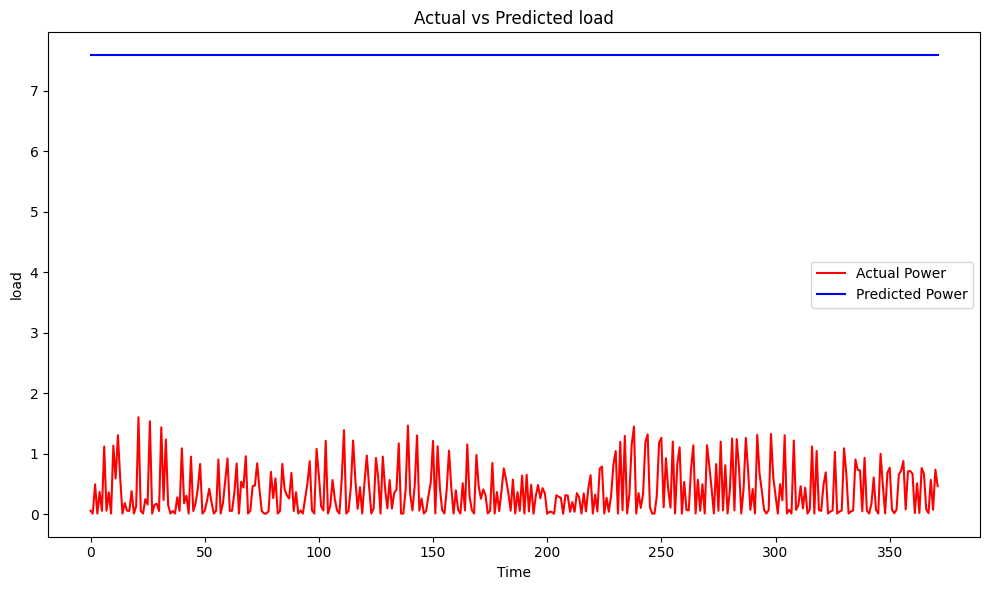

In [52]:
# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(train_features, train_label)

# Get XGBoost predictions for LSTM input
xgb_predictions = xgb_model.predict(train_features)
xgb_predictions = xgb_predictions.reshape((-1, 1))  # Reshape to add as LSTM input feature

# Combine XGBoost predictions with existing features
train_lstm_features = np.concatenate([train_features, xgb_predictions], axis=1)

# Reshape for LSTM
reshaped_train_lstm_features = train_lstm_features.reshape((train_lstm_features.shape[0], 1, train_lstm_features.shape[1]))

# Train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(1, reshaped_train_lstm_features.shape[2])))
lstm_model.add(Dense(1))  # Output layer

# Compile and train LSTM
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(reshaped_train_lstm_features, train_label, epochs=50, batch_size=64)

# Hybrid prediction: combine outputs
# lstm_predictions = lstm_model.predict(reshape_fn(test_dataset))
# final_predictions = (xgb_predictions + lstm_predictions) / 2  # Simple averaging
# plot_prediction(val_label,lstm_model.predict(val_features))
plot_prediction(test_label, lstm_model.predict(reshape_fn(test_dataset)))


In [45]:
test_features

,lag1_hour,lag2_hours,lag3_hours,lag1_day,hour,day,dayofweek,apparent_temperature,rain,wind_speed_10m,location_id
creation_time,,,,,,,,,,,
2024-07-28 21:00:00,0.0617,0.0371,0.0700,0.0833,21,28,6,35.0000,0.0000,7.6000,100000010001
2024-07-28 21:00:00,0.0100,0.0100,0.0100,0.0100,21,28,6,35.0000,0.0000,7.6000,100000010004
2024-07-28 22:00:00,0.9717,0.1350,0.1471,0.4400,22,28,6,34.7000,0.0000,8.3000,100000010103
2024-07-28 22:00:00,0.0100,0.0100,0.0100,0.0100,22,28,6,34.7000,0.0000,8.3000,100000010004
2024-07-28 22:00:00,0.3150,0.8467,0.1557,0.1300,22,28,6,34.7000,0.0000,8.3000,100000010003
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.0183,0.0200,0.0200,0.0100,23,31,2,31.4000,1.7000,13.4000,100000010004
2024-07-31 23:00:00,0.5167,0.4386,0.8000,1.2325,23,31,2,31.4000,1.7000,13.4000,100000010002
2024-07-31 23:00:00,0.0750,0.0733,0.0800,0.0717,23,31,2,31.4000,1.7000,13.4000,100000010001


In [11]:
df2 = final_df.copy()

In [12]:
train_dataset,test_dataset = common_obj.data_split_function(df2, target_variable= "Load_kW")

def scaling_layer(dataset,target_variable= "Load_kW"):
    scaler = MinMaxScaler()
    # Exclude the "Load_kW" column from features to normalize
    features_to_normalize = [col for col in dataset.columns if col != target_variable]

    dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
    with open('saved_model/minmax_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    return dataset
    # n dataset

def data_split(dataset, target_variable= "Load_kW"): 
    try:
        dataset_features = dataset.copy()
        dataset_label = dataset_features.pop(target_variable)
        # Split the dataset into training and test sets
        train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, 
                                                            random_state=42
                                                            )
        logger.info(f"data split done")
        logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
        logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
        return train_features, test_features, train_labels, test_labels

    except Exception as e:
        logger.error(f"error in data split: {e}",exc_info=True)

# # Scaling the data using MinMaxScaler
dataset_scaled = scaling_layer(train_dataset)

train_features, test_features, train_label, test_label = data_split(dataset_scaled)


# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
print(train_features.shape)
print(test_features.shape)

# Build LSTM model
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# # Adding dense output layer
model.add(Dense(units=1))  # Predicting the target variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(train_features, train_label, epochs=50, batch_size=64, validation_data=(test_features, test_label))

# # Save the model to a file
# model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
# history.save(f"saved_model/test/lstm_model_{model_version}.h5")

# # Prediction and evaluation
# self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)


(130344, 1, 15)
(14483, 1, 15)
Epoch 1/50
2037/2037 [==============================] - 10s 3ms/step - loss: 0.1416 - val_loss: 0.1299
Epoch 2/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1281 - val_loss: 0.1282
Epoch 3/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1272 - val_loss: 0.1282
Epoch 4/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1265 - val_loss: 0.1267
Epoch 5/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1261 - val_loss: 0.1267
Epoch 6/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1254 - val_loss: 0.1264
Epoch 7/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1249 - val_loss: 0.1250
Epoch 8/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1244 - val_loss: 0.1251
Epoch 9/50
2037/2037 [==============================] - 7s 3ms/step - loss: 0.1243 - val_loss: 0.1244
Epoch 10/50
2037/2037 [===========================

In [22]:
scores = model.predict(test_features)
scores

453/453 [==============================] - 1s 1ms/step


array([[-0.015],
       [-0.004],
       [ 0.335],
       ...,
       [ 0.821],
       [ 0.774],
       [ 1.438]], dtype=float32)

In [21]:

test_label

creation_time
2024-07-05 09:00:00   0.0000
2024-07-14 14:00:00   0.0000
2024-07-20 06:00:00   0.2560
2024-07-27 20:00:00   0.2373
2024-07-28 02:00:00   0.4080
                       ...  
2024-07-07 00:00:00   0.2200
2024-07-08 00:00:00   0.0320
2024-07-24 07:00:00   1.5917
2024-07-21 21:00:00   0.7520
2024-07-29 22:00:00   2.1340
Name: Load_kW, Length: 14483, dtype: float64

453/453 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Squared Error (MSE): 0.12046645355659066
Mean Absolute Error (MAE): 0.20899135941218502
Root Mean Squared Error (RMSE): 0.34708277623153627
R-squared: 0.5469383783313022


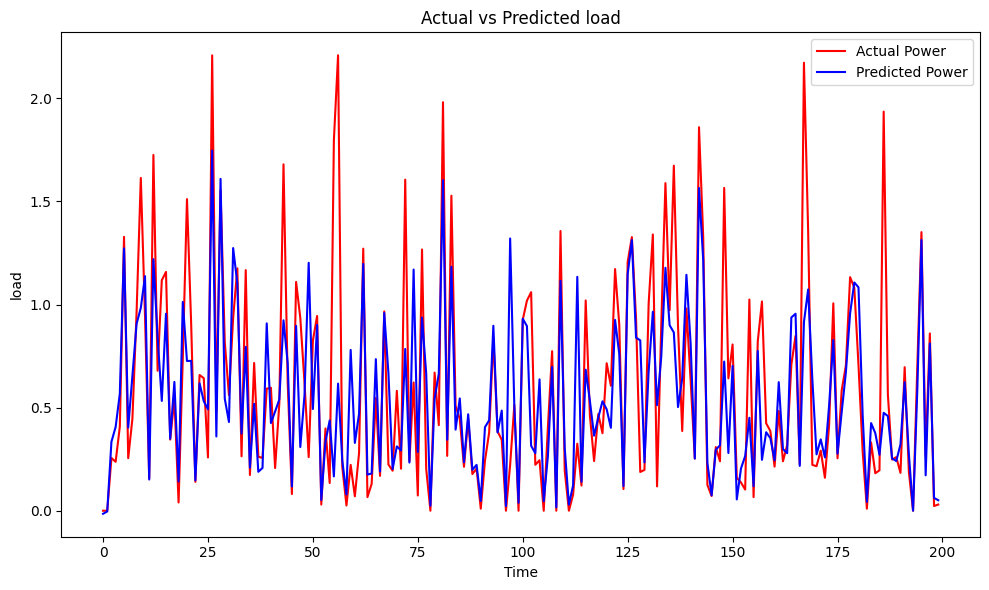

In [28]:
# def prediction(model, input_data, scoring=False, test_data= None,prediction= False):
#     try:
# if prediction:
#     # scaler= scaler_value()

#     input_data = scaler.transform(input_data)

# Step 6: Make predictions
values = 200
y_pred = model.predict(test_features)
if y_pred is not None:
    logger.info("predition_succesful")

actual = test_label[0:values]
predicted = y_pred[0:values]

# if scoring :
# Step 7: Evaluate the model
rmse = sqrt(mean_squared_error(actual, predicted))
print("\nModel Power Evaluation")
print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print("R-squared:", r2_score(actual, predicted))
# logger.info(f"\nModel Evaluation")
# logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
# logger.info(f"Mean Squared Error (MSE): {mean_squared_error(test_label, y_pred)}")
# logger.info(f"Mean Absolute Error (MAE): {mean_absolute_error(test_label, y_pred)}")
# logger.info(f"R-squared: {r2_score(test_label, y_pred)}")

# Scatter plot
plt.figure(figsize=(10, 6))
# Plot actual values in red
plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
# Plot predicted values in blue
plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
# Adding labels and title
plt.xlabel('Time')
plt.ylabel('load')
plt.title('Actual vs Predicted load')
plt.legend()
plt.tight_layout()
plt.show()

# return y_pred
# except Exception as e:
# logger.error(f"error in prediction: {e}",exc_info=True)
# pred =

In [29]:
test_dataset

,Load_kW,location_id,apparent_temperature,rain,wind_speed_10m,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag2_days,lag3_days,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,holiday
creation_time,,,,,,,,,,,,,,,,,,
2024-07-12 12:00:00,0.2367,100000040705,34.7000,1.0000,14.8000,0.1250,0.0900,0.0943,0.3967,0.3820,0.0900,0.3200,12,12,28,4,0,0.0000
2024-07-12 13:00:00,1.1814,100000040705,38.0000,0.0000,6.1000,0.3667,0.1250,0.0900,1.1286,0.3883,0.2033,0.3283,13,12,28,4,0,0.0000
2024-07-12 14:00:00,1.3700,100000040705,36.9000,0.0000,5.1000,0.3900,0.3667,0.1250,1.7100,0.3900,0.6243,0.1783,14,12,28,4,0,0.0000
2024-07-12 15:00:00,0.4240,100000040705,36.4000,0.0000,4.6000,0.3871,0.3900,0.3667,1.8900,0.4317,0.2600,0.2471,15,12,28,4,0,0.0000
2024-07-12 16:00:00,0.2767,100000040705,36.0000,0.0000,5.5000,0.3900,0.3871,0.3900,0.2371,1.0217,0.2700,0.3283,16,12,28,4,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.4950,100000190011,31.3000,25.1000,19.3000,0.3550,1.5383,1.1214,0.5067,0.8867,0.6786,0.8600,19,31,31,2,0,0.0000
2024-07-31 20:00:00,0.1000,100000190011,32.7000,15.3000,10.8000,0.4950,0.3550,1.5383,0.3371,0.4260,0.6367,0.6367,20,31,31,2,0,0.0000
2024-07-31 21:00:00,0.1000,100000190011,33.3000,6.0000,7.8000,0.1000,0.4950,0.3550,0.1000,0.0900,0.0900,0.1386,21,31,31,2,0,0.0000


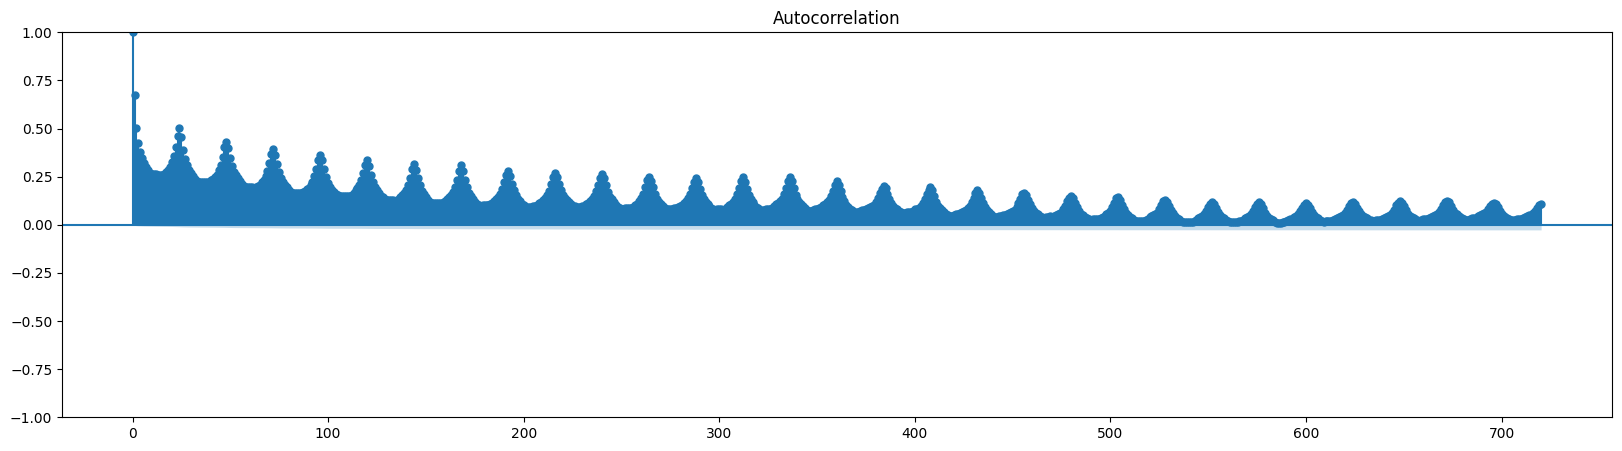

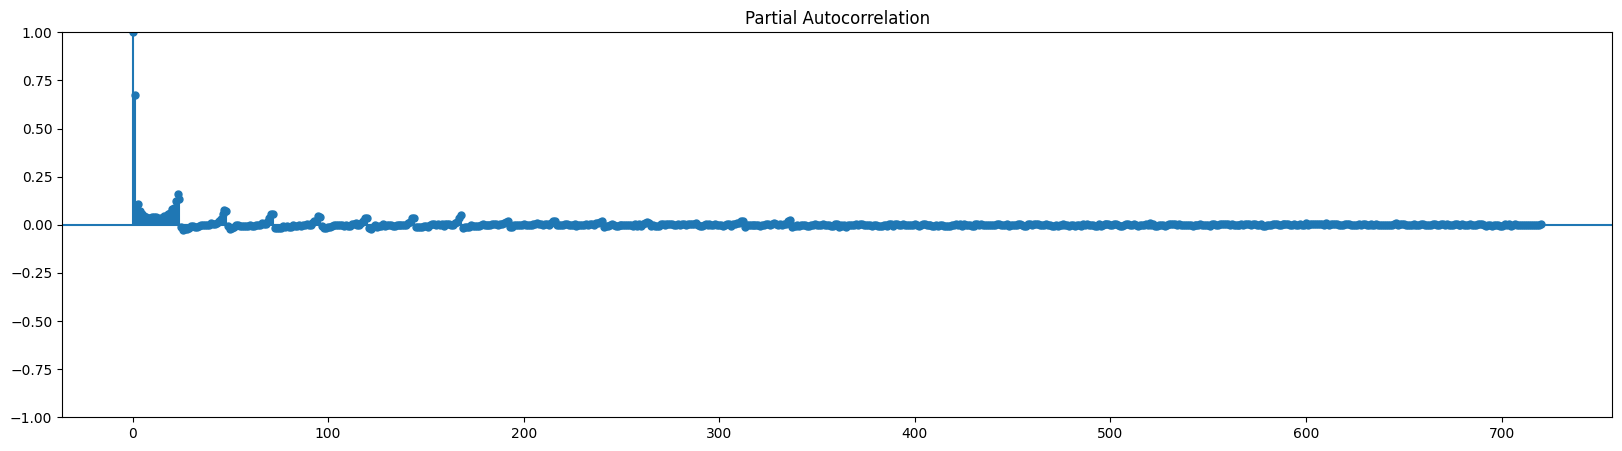

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(df2['Load_kW'], lags=720)
plt.show()

plot_pacf(df2['Load_kW'], lags=720)
plt.show()


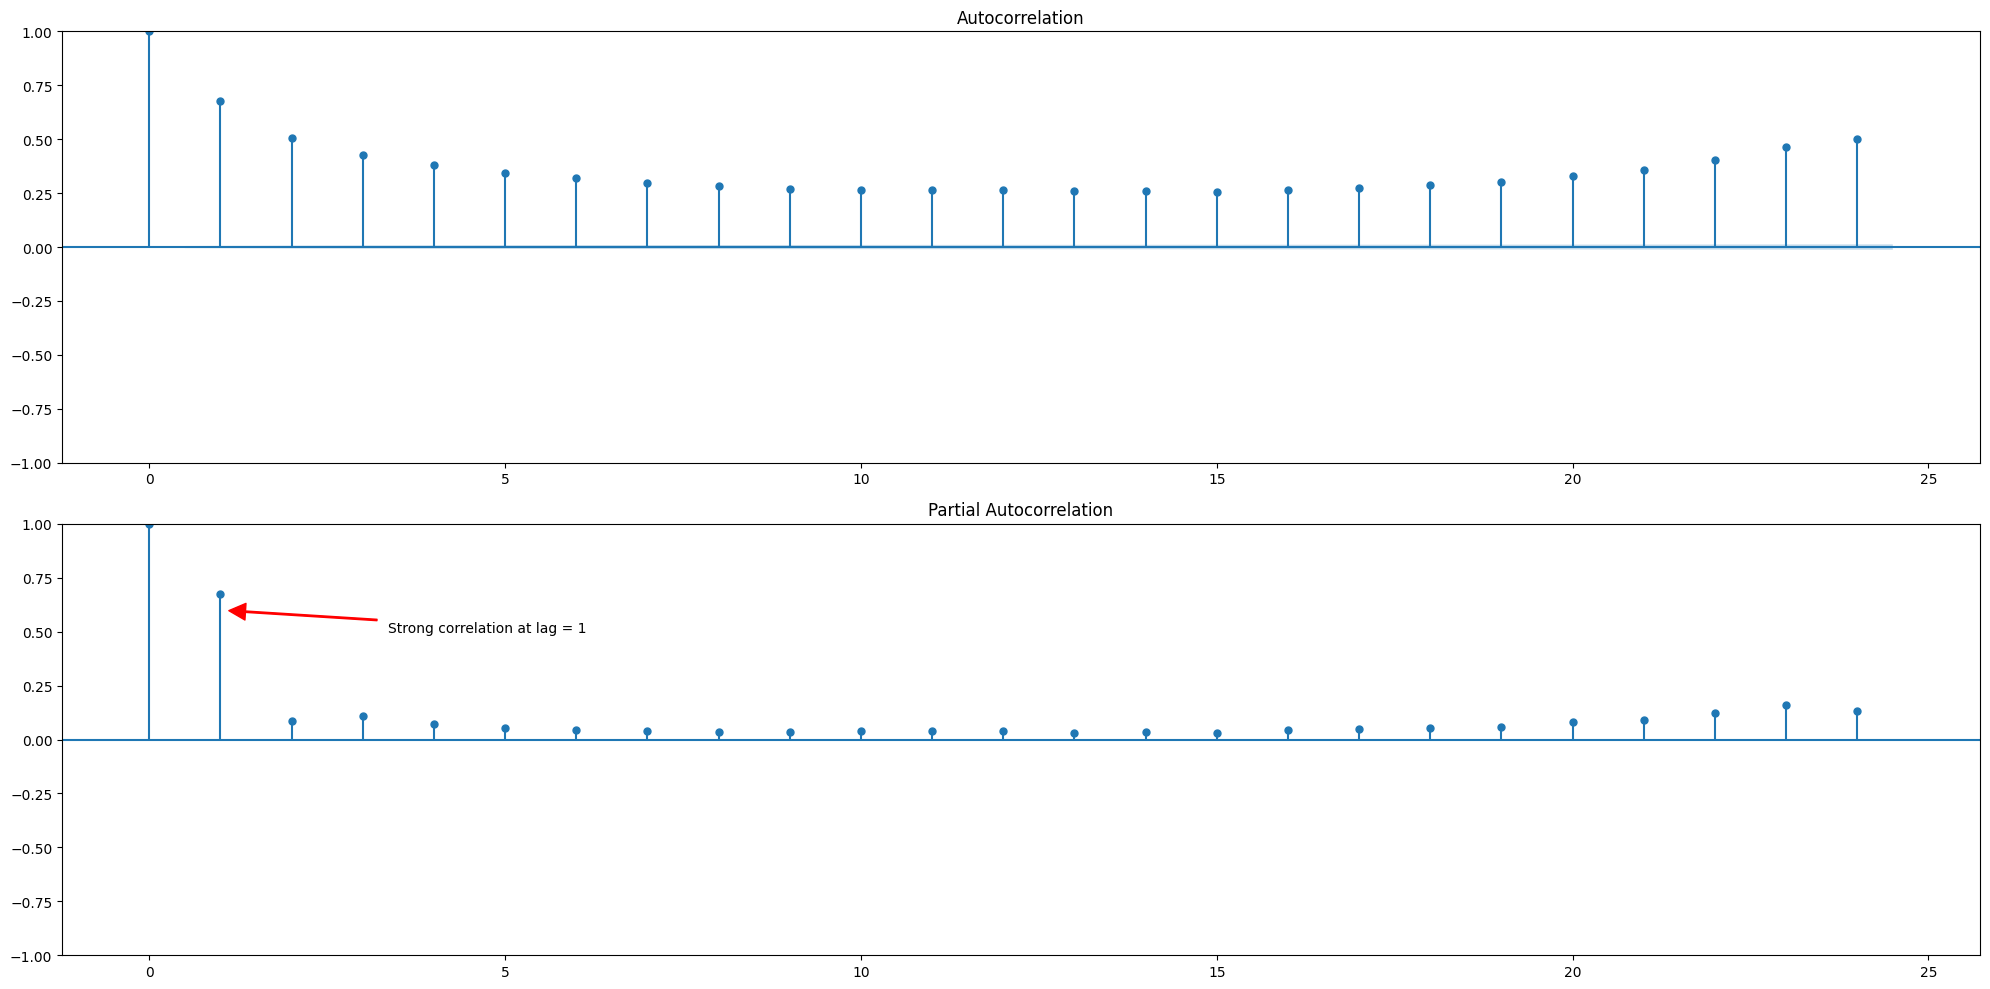

In [34]:
lag_acf = 24
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df2['Load_kW'],lags=lag_acf, ax=ax[0])
plot_pacf(df2['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

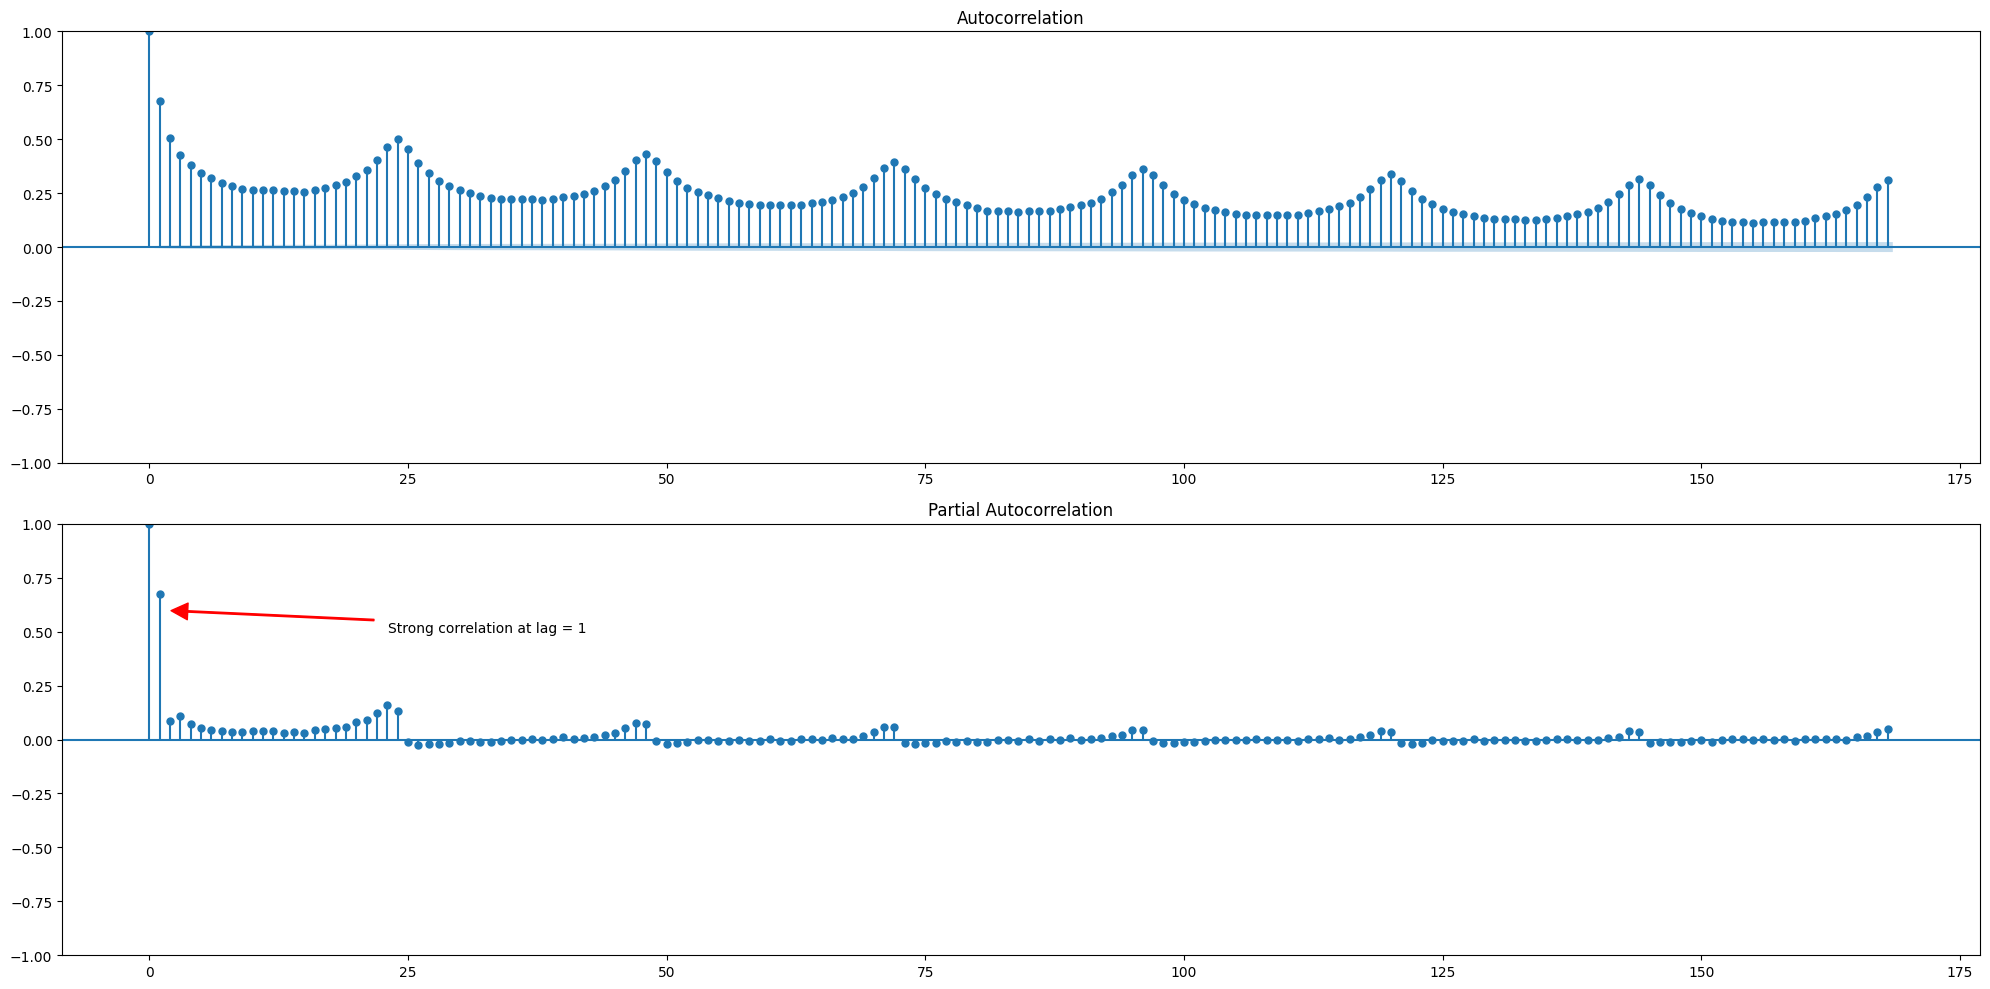

In [36]:
lag_acf = 24*7
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df2['Load_kW'],lags=lag_acf, ax=ax[0])
plot_pacf(df2['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

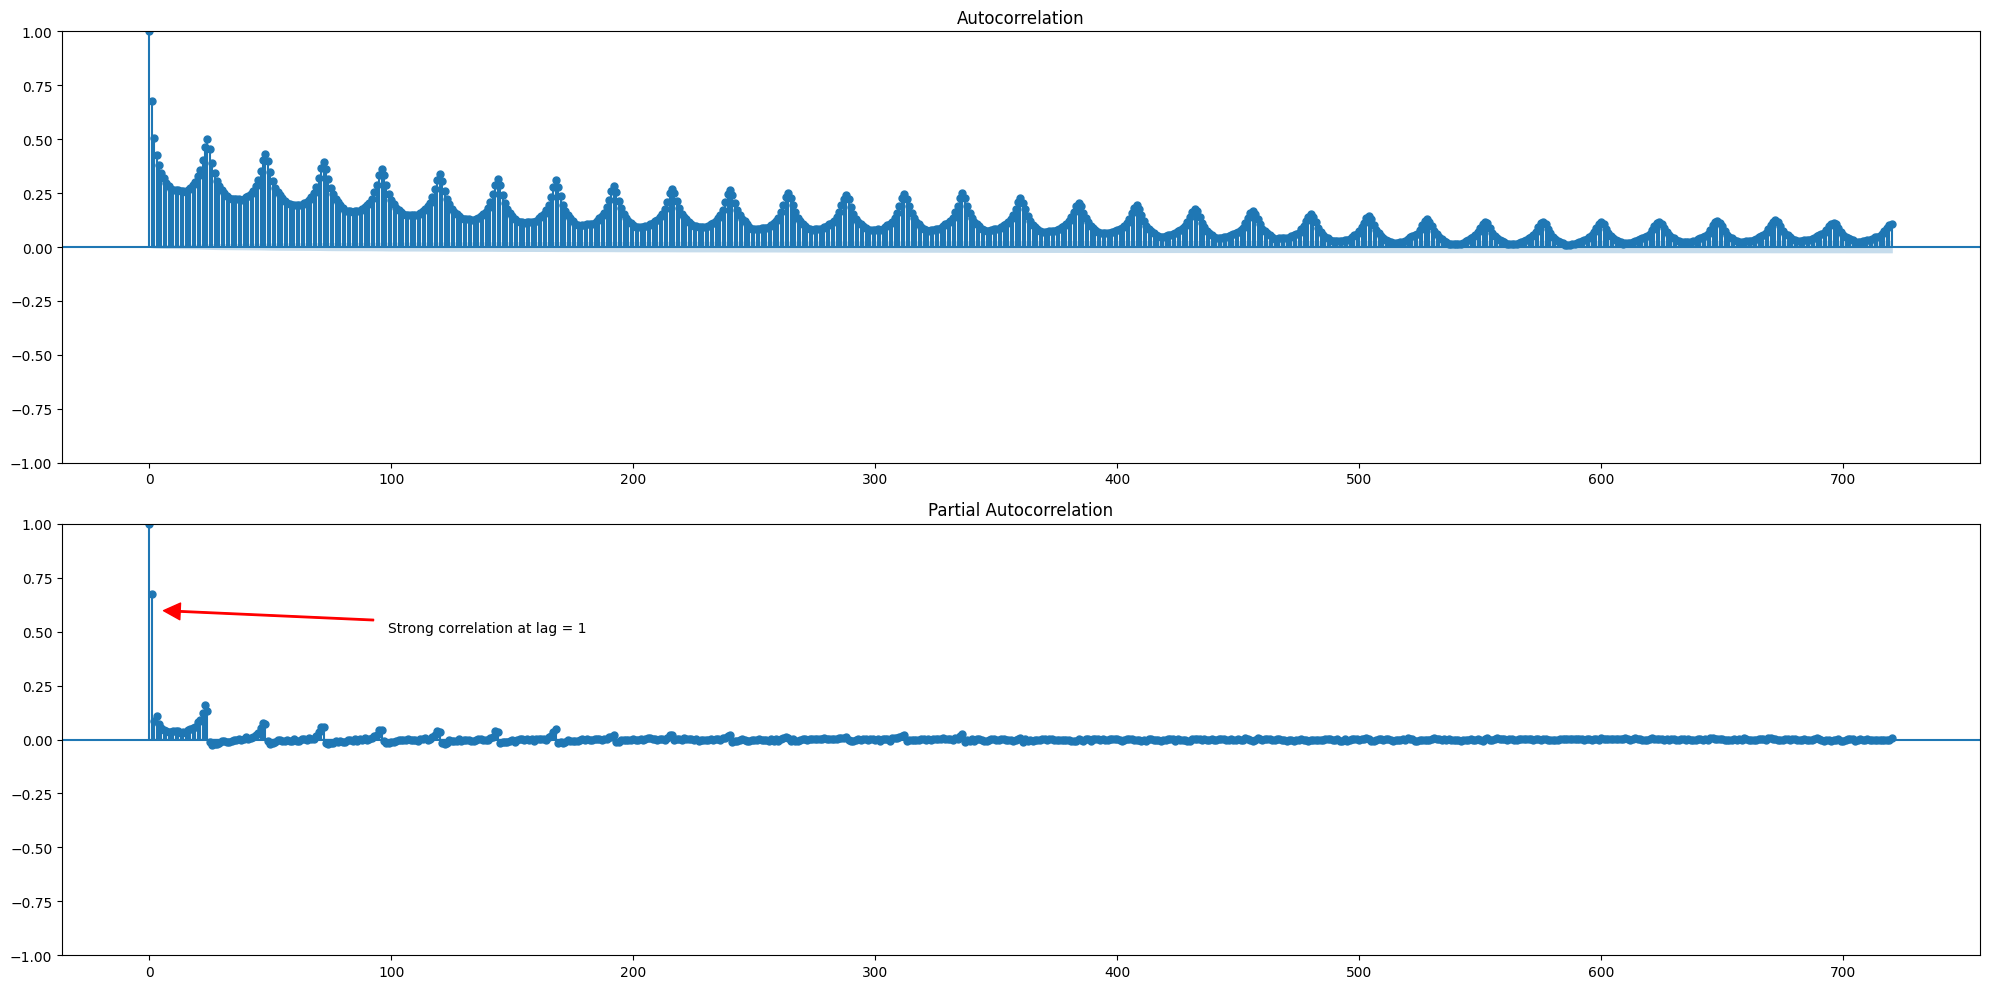

In [37]:
lag_acf = 24*30
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df2['Load_kW'],lags=lag_acf, ax=ax[0])
plot_pacf(df2['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

In [39]:
df2.sort_index(inplace=True)
df2

,Load_kW,location_id,apparent_temperature,rain,wind_speed_10m,lag1_hour,lag3_hours,lag1_day,lag1_week,lag2_hours,lag6_hours,lag2_days,lag3_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday
creation_time,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.0617,100000010001,30.4000,3.9000,9.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,0
2024-07-01 00:00:00,1.6833,100000040103,30.4000,3.9000,9.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,0
2024-07-01 00:00:00,1.0650,100000011201,30.4000,3.9000,9.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,0
2024-07-01 00:00:00,0.7875,100000040104,30.4000,3.9000,9.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,0
2024-07-01 00:00:00,1.1083,100000011106,30.4000,3.9000,9.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,27,183,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:00:00,0.3520,100000021402,31.4000,1.7000,13.4000,0.1000,0.1000,0.0957,0.0900,0.1000,1.5383,0.0900,0.0900,23,31,2,31,213,0,0
2024-07-31 23:00:00,1.3450,100000010805,31.4000,1.7000,13.4000,0.1000,0.1000,0.0957,0.0900,0.1000,1.5383,0.0900,0.0900,23,31,2,31,213,0,0
2024-07-31 23:00:00,1.1000,100000030605,31.4000,1.7000,13.4000,0.1000,0.1000,0.0957,0.0900,0.1000,1.5383,0.0900,0.0900,23,31,2,31,213,0,0


from_date:  2024-07-01 to_date:  2024-07-31
holidays_lst: [datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28)]


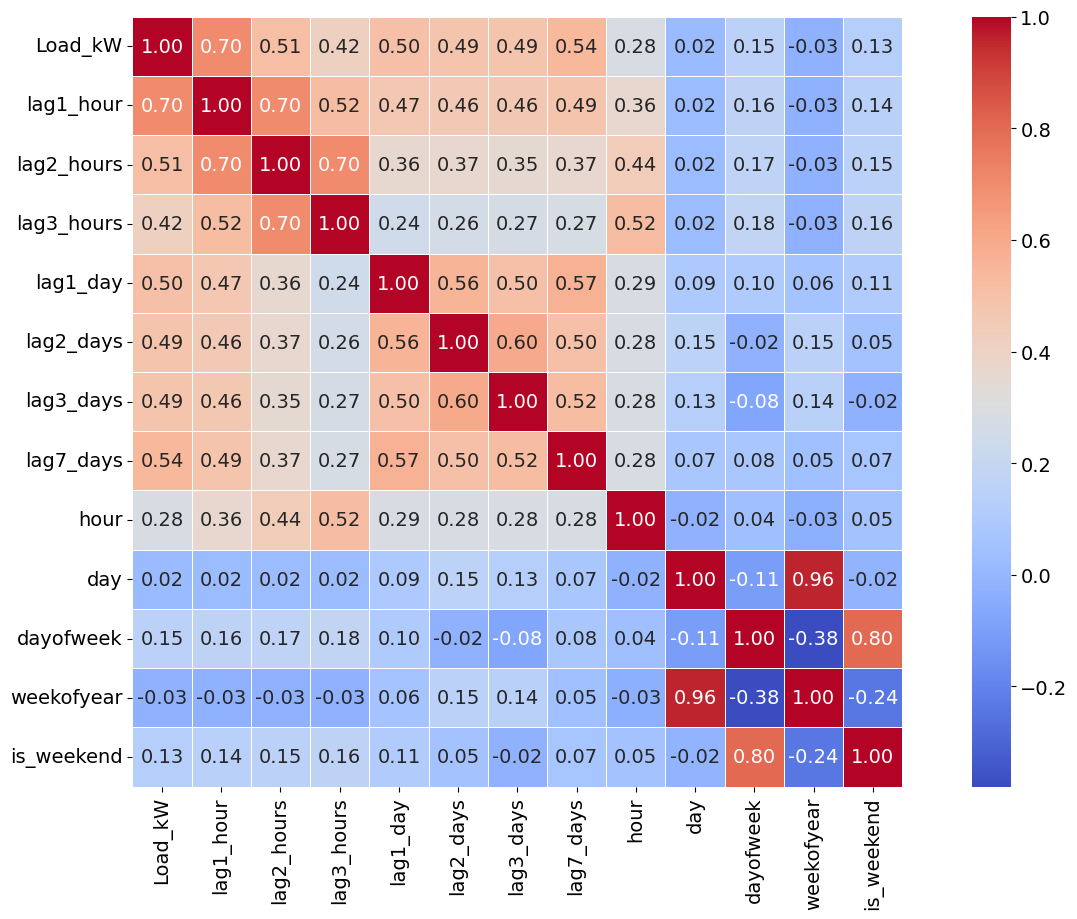

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag2_days,lag3_days,lag7_days,hour,day,dayofweek,weekofyear,is_weekend
creation_time,,,,,,,,,,,,,
2024-07-08 00:00:00,0.1000,0.1600,0.1260,0.0900,0.0300,0.5900,0.0000,0.0000,0,8,0,28,0
2024-07-08 01:00:00,0.0900,0.1000,0.1600,0.1260,0.0300,0.6083,0.0000,0.0000,1,8,0,28,0
2024-07-08 02:00:00,0.1600,0.0900,0.1000,0.1600,0.0300,0.3880,0.0000,0.0000,2,8,0,28,0
2024-07-08 03:00:00,0.1167,0.1600,0.0900,0.1000,0.0300,0.3843,0.0000,0.0000,3,8,0,28,0
2024-07-08 04:00:00,0.1229,0.1167,0.1600,0.0900,0.0300,0.3967,0.0000,0.0000,4,8,0,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 12:00:00,0.4200,0.4233,0.4167,0.3483,0.0000,0.0000,2.1867,0.3100,12,31,2,31,0
2024-07-31 13:00:00,2.3543,0.4200,0.4233,0.4167,0.0000,1.2083,2.0167,0.3100,13,31,2,31,0
2024-07-31 14:00:00,1.2883,2.3543,0.4200,0.4233,0.3500,2.4843,2.0883,0.3100,14,31,2,31,0


In [42]:
from common_functions import NPCL, common
npcl_obj = NPCL()
common_obj  = common()
testing_obj = testing()

# df1 = common_obj.add_lags(resample_df,target_col="Load_kW")
# df2 = common_obj.create_features(df1)
# latitude,longitude = "27.34019480", "72.93117380"

latitude, longitude = "28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
# weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date,duration="15min")

holidays_lst= common_obj.holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)

df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW",large_data=True)
df2 = testing_obj.create_features(df_lags,lagre_data=True)
# for date in holidays_lst:
#     df2.loc[f"{date}", 'holiday'] = 1
# df2.fillna(0,inplace= True)
df2.dropna(inplace=True)
# df3 = df2.merge(weather_df,on=["creation_time"])
# df3.drop(['creation_time'],axis=1,inplace=True)
common_obj.correlation_matrix(df2)
df2

In [ ]:
train_dataset,test_dataset = common_obj.data_split_function(df3, target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
testing_obj = testing()
model= testing_obj.lstm_model_trainer(train_dataset, target_variable= "Load_kW")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)
logger.info(f"####################################################################################################################################")


In [ ]:

train_dataset,test_dataset = common_obj.data_split_function(df3, target_variable= "Load_kW")

def scaling_layer(dataset,target_variable= "Load_kW"):
    scaler = MinMaxScaler()
    # Exclude the "Load_kW" column from features to normalize
    features_to_normalize = [col for col in dataset.columns if col != target_variable]

    dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
    with open('saved_model/minmax_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    return dataset
    # n dataset

def data_split(dataset, target_variable= "Load_kW"): 
    try:
        dataset_features = dataset.copy()
        dataset_label = dataset_features.pop(target_variable)
        # Split the dataset into training and test sets
        train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, 
                                                            random_state=42
                                                            )
        logger.info(f"data split done")
        logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
        logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
        return train_features, test_features, train_labels, test_labels

    except Exception as e:
        logger.error(f"error in data split: {e}",exc_info=True)

# # Scaling the data using MinMaxScaler
dataset_scaled = scaling_layer(train_dataset)

train_features, test_features, train_label, test_label = data_split(dataset_scaled)


# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
print(train_features.shape)
print(test_features.shape)

# Build LSTM model
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# # Adding dense output layer
model.add(Dense(units=1))  # Predicting the target variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(train_features, train_label, epochs=100, batch_size=64, validation_data=(test_features, test_label))

# # Save the model to a file
# model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
# history.save(f"saved_model/test/lstm_model_{model_version}.h5")

# # Prediction and evaluation
# self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)



Model Power Evaluation
Mean Squared Error (MSE): 0.21884118712298595
Mean Absolute Error (MAE): 0.30697450605903664
R-squared: 0.27307737556709744


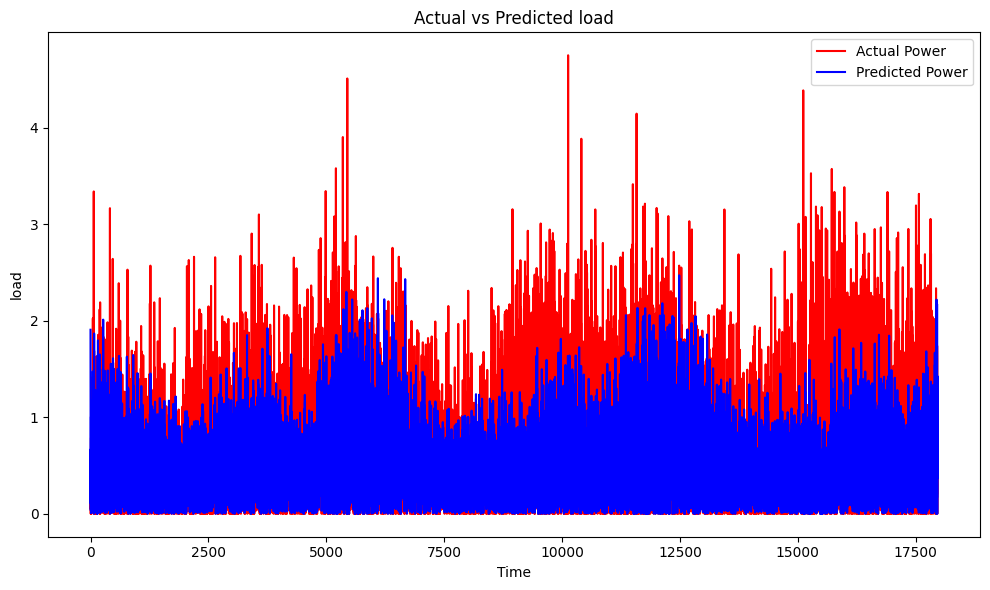

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from logger import logger

import joblib
def data_split_function(dataset, target_variable= "Load_kW"):
        try:
            n = len(dataset)
            train_df = dataset[0:int(n*0.9)]
            test_df = dataset[int(n*0.9):]
            train_features, test_features = train_df.copy(),test_df.copy() #,val_df.copy()
            train_labels = train_features.pop(target_variable)
            test_labels = test_features.pop(target_variable)
            
            # print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            # print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"data split done")
            logger.info(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            return train_features,test_features,train_labels, test_labels
        
        except Exception as e:
            logger.error(f"error in split: {e}",exc_info=True)


def model_trainer1(train_fetures, train_label,model_name=None):
        try:
            logger.info(f"###############################################################################################start")
            # dataset = train_fetures.merge(train_label, on="creation_time").copy()
            dataset = train_fetures.merge(train_label, left_index=True, right_index=True).copy()
            # dataset = X_train_scaled.merge(y_train_df, left_index=True, right_index=True).copy()

            # print(dataset.columns)
            # Split the dataset into training and test sets
            X_train, X_test, y_train, y_test = data_split_function(dataset=dataset)

            if model_name =="RFR":
                # Step 4: Initialize the RandomForestRegressor model
                model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tweak hyperparameters

            # Step 5: Train the model
            model.fit(X_train, y_train)
            logger.info(f"model trained")
            
            prediction(model= model,
                            input_data= X_test,
                            scoring= True,
                            test_data= y_test)
            # Save the model to a file
            joblib.dump(model, 'forecasting_model.pkl')
            logger.info(f"############################################################################################## end")

            return model
        except Exception as e:
            logger.error(f"error in model trainer: {e}",exc_info=True)

def scaling_layer(datset):
        try:
            scaler = MinMaxScaler()
            features_to_normalize = datset.columns
            datset[features_to_normalize] = scaler.fit_transform(datset[features_to_normalize])
            return datset
        
        except Exception as e:
            logger.error(f"error in scaling: {e}",exc_info= True)    

def prediction(model, input_data, scoring=False, test_data= None,prediction= False):
    try:
        if prediction:
            input_data = scaling_layer(input_data)

        # Step 6: Make predictions
        y_pred = model.predict(input_data)
        if y_pred is not None:
            logger.info("predition_succesful")

        if scoring :
            # Step 7: Evaluate the model
            print("\nModel Power Evaluation")
            print("Mean Squared Error (MSE):", mean_squared_error(test_data, y_pred))
            print("Mean Absolute Error (MAE):", mean_absolute_error(test_data, y_pred))
            print("R-squared:", r2_score(test_data, y_pred))
        
            # Scatter plot
            plt.figure(figsize=(10, 6))
            # Plot actual values in red
            plt.plot(range(len(test_data)), test_data, color='red', label='Actual Power')
            # Plot predicted values in blue
            plt.plot(range(len(y_pred)), y_pred, color='blue', label='Predicted Power')
            # Adding labels and title
            plt.xlabel('Time')
            plt.ylabel('load')
            plt.title('Actual vs Predicted load')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        return y_pred
    except Exception as e:
        logger.error(f"error in prediction: {e}",exc_info=True)

model= model_trainer1(X_train_scaled[['location_id', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours', 'lag1_day',  'lag2_days', 'hour', 'day', 'dayofweek','is_weekend', 'relative_humidity_2m', 'rain','wind_speed_10m']]
                      ,y_train_df,model_name="RFR")

In [29]:
X_train_scaled

,location_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m,lag1_hour,lag2_hours,lag3_hours,lag6_hours,lag12_hours,lag1_day,lag1_week,lag2_days,lag3_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday
0,0.0000,0.0000,0.9318,0.0299,0.2786,0.2786,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.1200,0.0000,0.9318,0.0299,0.2786,0.2786,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0561,0.0000,0.9318,0.0299,0.2786,0.2786,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0061,0.0000,0.9318,0.0299,0.2786,0.2786,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.1167,0.0000,0.9318,0.0299,0.2786,0.2786,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179641,0.0606,0.3084,0.7045,0.3731,0.0000,0.0000,0.2971,0.4081,0.3369,0.3590,0.1270,0.3416,0.0529,0.0529,0.0476,0.0529,0.7196,0.9130,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
179642,0.0567,0.3084,0.7045,0.3731,0.0000,0.0000,0.2971,0.4081,0.3369,0.3590,0.1270,0.3416,0.0529,0.0529,0.0476,0.0529,0.7196,0.9130,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
179643,0.1728,0.3084,0.7045,0.3731,0.0000,0.0000,0.2971,0.4081,0.3369,0.3590,0.1270,0.3416,0.0529,0.0529,0.0476,0.0529,0.7196,0.9130,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
179644,0.1194,0.3084,0.7045,0.3731,0.0000,0.0000,0.2971,0.4081,0.3369,0.3590,0.1270,0.3416,0.0529,0.0529,0.0476,0.0529,0.7196,0.9130,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [81]:
X_train

,location_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m,lag1_hour,lag2_hours,lag3_hours,lag6_hours,lag12_hours,lag1_day,lag1_week,lag2_days,lag3_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday
creation_time,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.0000,0.0000,0.9318,0.0265,0.0658,0.0658,0.3891,0.3486,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2024-07-01 01:00:00,0.0000,0.2321,0.7727,0.3245,0.0000,0.0000,0.0753,0.0514,0.0658,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0435,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2024-07-01 02:00:00,0.0000,0.3036,0.6591,0.3311,0.0000,0.0000,0.2469,0.2054,0.0635,0.0658,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0870,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2024-07-01 03:00:00,0.0000,0.4107,0.5000,0.3775,0.0000,0.0000,0.3305,0.2784,0.0608,0.0635,0.0658,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1304,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2024-07-01 04:00:00,0.0000,0.5179,0.4091,0.4702,0.0000,0.0000,0.3222,0.2649,0.0600,0.0608,0.0635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1739,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-06 02:00:00,1.0000,0.1607,0.7955,0.1589,0.0000,0.0000,0.4393,0.3811,0.0444,0.0423,0.0423,0.0423,0.0944,0.0466,0.0000,0.0582,0.0529,0.0870,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 03:00:00,1.0000,0.2857,0.6364,0.2715,0.0017,0.0017,0.3556,0.3027,0.0476,0.0444,0.0423,0.0423,0.1308,0.0529,0.0000,0.0605,0.0529,0.1304,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 04:00:00,1.0000,0.3571,0.5455,0.3444,0.0034,0.0034,0.2678,0.2243,0.0476,0.0476,0.0444,0.0423,0.1737,0.0529,0.0000,0.0626,0.0529,0.1739,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000


In [82]:
y_train

creation_time
2024-07-01 00:00:00   0.0617
2024-07-01 01:00:00   0.0771
2024-07-01 02:00:00   0.0400
2024-07-01 03:00:00   0.0483
2024-07-01 04:00:00   0.0433
                       ...  
2024-07-06 02:00:00   0.2843
2024-07-06 03:00:00   0.1350
2024-07-06 04:00:00   0.2017
2024-07-06 05:00:00   0.2633
2024-07-06 06:00:00   0.2233
Name: Load_kW, Length: 179646, dtype: float64

In [86]:
X_test

,location_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m,lag1_hour,lag2_hours,lag3_hours,lag6_hours,lag12_hours,lag1_day,lag1_week,lag2_days,lag3_days,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday
creation_time,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-06 07:00:00,0.0000,0.5536,0.2727,0.4437,0.0000,0.0000,0.3640,0.2919,0.0476,0.0476,0.0476,0.0444,0.1481,0.0529,0.0000,0.0600,0.0485,0.3043,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 08:00:00,0.0000,0.6964,0.1364,0.6755,0.0000,0.0000,0.2259,0.1811,0.0476,0.0476,0.0476,0.0476,0.0423,0.0529,0.0000,0.0582,0.0547,0.3478,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 09:00:00,0.0000,0.6875,0.1591,0.5629,0.0000,0.0000,0.3013,0.2378,0.0431,0.0476,0.0476,0.0476,0.0423,0.0529,0.0000,0.0582,0.0529,0.3913,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 10:00:00,0.0000,0.5446,0.3409,0.4172,0.0051,0.0051,0.5481,0.4649,0.0423,0.0431,0.0476,0.0476,0.0423,0.0520,0.0000,0.0564,0.0529,0.4348,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
2024-07-06 11:00:00,0.0000,0.5089,0.3864,0.4172,0.0034,0.0034,0.4728,0.4027,0.0423,0.0423,0.0431,0.0476,0.0423,0.0650,0.0000,0.0829,0.1247,0.4783,0.1667,0.8333,0.0000,0.1667,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,1.0000,0.1250,0.9318,0.0861,0.4233,0.4233,0.7866,0.8270,0.1878,0.8139,0.5933,0.1088,0.0529,0.2681,0.4550,0.4691,0.3590,0.8261,1.0000,0.3333,1.0000,1.0000,0.0000,0.0000
2024-07-31 20:00:00,1.0000,0.1339,0.9318,0.1788,0.2580,0.2580,0.4310,0.4973,0.2619,0.1878,0.8139,0.4709,0.0529,0.1784,0.3369,0.2254,0.3369,0.8696,1.0000,0.3333,1.0000,1.0000,0.0000,0.0000
2024-07-31 21:00:00,1.0000,0.1339,0.9545,0.2185,0.1012,0.1012,0.3054,0.3432,0.0529,0.2619,0.1878,0.5723,0.0499,0.0529,0.0733,0.0476,0.0476,0.9130,1.0000,0.3333,1.0000,1.0000,0.0000,0.0000


In [84]:
y_test

creation_time
2024-07-06 07:00:00   0.1567
2024-07-06 08:00:00   0.3257
2024-07-06 09:00:00   0.3283
2024-07-06 10:00:00   0.7967
2024-07-06 11:00:00   1.3971
                       ...  
2024-07-31 19:00:00   0.4950
2024-07-31 20:00:00   0.1000
2024-07-31 21:00:00   0.1000
2024-07-31 22:00:00   0.1000
2024-07-31 23:00:00   0.1000
Name: Load_kW, Length: 19961, dtype: float64

In [8]:
zero_df = data[data['Load_kW']!=0]
zero_df

,location_id,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
creation_time,,,,,,,,,,,
2024-07-01 00:00:00,100000020805,243.1000,246.2000,240.9000,0.0000,0.0000,0.2600,1.0000,1.0000,1.0000,0.0700
2024-07-01 00:00:00,100000031104,243.8000,247.0000,241.5000,0.2600,1.6100,0.7000,1.0000,0.9900,0.7300,0.6400
2024-07-01 00:00:00,100000040406,243.0000,247.1000,242.5000,0.2200,0.0000,1.4400,1.0000,1.0000,1.0000,0.4500
2024-07-01 00:00:03,100000040701,243.1000,246.9000,242.1000,3.6900,3.3000,0.6300,0.9700,0.9900,0.8000,1.8000
2024-07-01 00:00:03,100000020806,243.0000,246.7000,240.8000,0.0000,6.6500,0.0000,1.0000,1.0000,1.0000,1.6400
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:59:53,100000020006,248.4000,250.8000,249.1000,0.0000,0.0000,0.5800,1.0000,1.0000,0.9700,0.1400
2024-07-31 23:59:53,100000030505,249.5000,250.2000,249.0000,0.2000,0.0800,6.3900,0.9800,1.0000,0.9900,1.6600
2024-07-31 23:59:55,100000041205,248.3000,251.5000,247.8000,0.0000,0.2900,2.0800,1.0000,0.6700,0.9300,0.5200


In [8]:
zero_df.groupby('location_id')[['Load_kW']].mean()

,Load_kW
location_id,
100000010001,0.1179
100000010002,0.9339
100000010003,0.5590
100000010004,0.0120
100000010101,1.3267
...,...
100000041404,0.7375
100000050306,0.9400
100000190001,3.3049


In [87]:
dit = {}
df_lst = []
# Loop through each location_id group in zero_df
for id, data2 in zero_df.groupby('location_id'):
    Q1 = data2['Load_kW'].quantile(0.25)
    Q3 = data2['Load_kW'].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range
    upper_bound = Q3 + 3.5 * IQR  # Upper bound for outliers
    df_lst.append(data2[data2['Load_kW']>upper_bound])
    # data2[data2['Load_kW']>upper_bound]
load_df2 = pd.concat(df_lst)
load_df2

,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
141,100000010001,2024-07-01 23:51:03,238.3000,241.2000,239.3000,0.0000,1.3000,0.0000,1.0000,0.9900,1.0000,0.3100
142,100000010001,2024-07-02 00:00:26,238.3000,241.2000,239.3000,0.0000,1.3000,0.0000,1.0000,0.9900,1.0000,0.3100
347,100000010001,2024-07-03 11:31:07,237.9000,240.8000,238.3000,0.0000,1.3000,0.0000,1.0000,0.9900,1.0000,0.3100
348,100000010001,2024-07-03 11:40:30,237.7000,240.5000,238.7000,0.0000,1.2900,0.0000,1.0000,0.9900,1.0000,0.3100
349,100000010001,2024-07-03 11:50:04,237.6000,241.1000,238.2000,0.0000,0.5000,0.0000,1.0000,0.9800,1.0000,0.3100
...,...,...,...,...,...,...,...,...,...,...,...,...
1933959,100000190011,2024-07-31 17:27:57,241.4000,245.9000,245.4000,0.0000,6.9700,0.0000,1.0000,0.9800,1.0000,1.6800
1933960,100000190011,2024-07-31 17:37:28,241.4000,245.9000,245.4000,0.0000,6.9700,0.0000,1.0000,0.9800,1.0000,1.6800
1933961,100000190011,2024-07-31 17:46:53,244.1000,248.5000,248.0000,0.0000,6.9000,0.0000,1.0000,0.9800,1.0000,1.6800
1936397,100000190016,2024-07-18 13:50:19,235.4000,236.9000,234.4000,0.0000,0.0000,13.7200,1.0000,1.0000,0.9900,3.1900


In [91]:
load_df3 = load_df2.groupby('location_id')[['Load_kW']].count()
load_df3[load_df3['Load_kW']<10]

,Load_kW
location_id,
100000010304,6
100000010502,4
100000010604,3
100000010605,3
100000010704,3
100000010801,1
100000010805,2
100000010806,1
100000011201,4


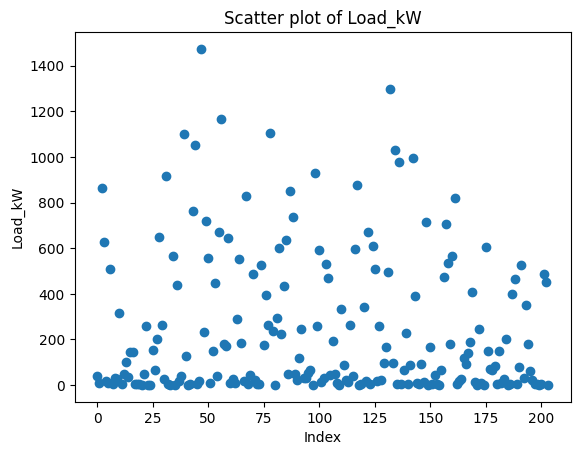

In [90]:
# plt.scatter(range(len(load_df2),load_df2[['Load_kW']]))
plt.scatter(range(len(load_df3)), load_df3['Load_kW'])
plt.xlabel("Index")
plt.ylabel("Load_kW")
plt.title("Scatter plot of Load_kW")
plt.show()


In [66]:
dit = {}
for id, data2 in zero_df.groupby('location_id'):
    Q1 = data2['Load_kW'].quantile(0.25)
    Q3 = data2['Load_kW'].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
    mean_Load_kW = data2['Load_kW'].mean()

    # Append the results for each location_id into load_df2
    dit[id]={'mean_Load_kW': mean_Load_kW,
        'upper_bound': upper_bound}
    
    # load_df2 = load_df2.append({
    #     'location_id': id,
        
    # }, ignore_index=True)
# Display the resulting DataFrame
load_df2 = pd.DataFrame(dit)
load_df2.transpose()

,mean_Load_kW,upper_bound
100000010001,0.1179,0.1600
100000010002,0.9339,3.1700
100000010003,0.5590,1.8000
100000010004,0.0120,0.0100
100000010101,1.3267,3.4850
...,...,...
100000041404,0.7375,0.9800
100000050306,0.9400,3.7200
100000190001,3.3049,11.9150
100000190011,0.3181,0.6500


61
[100000010101 100000010104 100000010301 100000010402 100000010404
 100000010505 100000010702 100000010705 100000010706 100000010801
 100000010804 100000010902 100000010903 100000010906 100000011003
 100000011004 100000011202 100000011203 100000011403 100000011404
 100000020004 100000020101 100000021706 100000030002 100000030003
 100000030106 100000030201 100000030302 100000030303 100000030402
 100000030406 100000030501 100000030504 100000030701 100000030902
 100000030903 100000031005 100000031102 100000031103 100000031506
 100000031605 100000031701 100000031705 100000031802 100000031803
 100000031906 100000040004 100000040206 100000040402 100000040403
 100000040502 100000040504 100000040506 100000040701 100000040903
 100000041005 100000041006 100000041104 100000041202 100000041203
 100000190001]


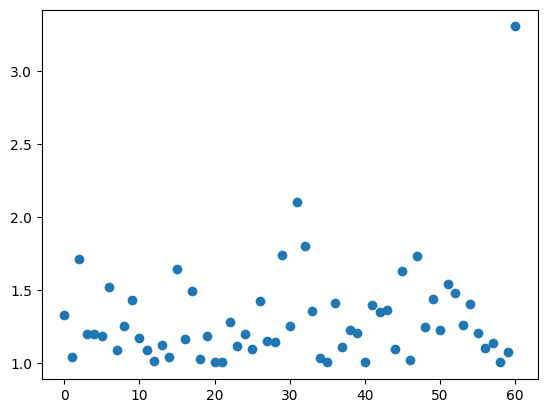

In [9]:

threshold_value = 1
load_df = zero_df.groupby('location_id')[['Load_kW']].mean()
print(len(load_df[load_df['Load_kW']>threshold_value]))

location_lst = np.array(load_df[load_df['Load_kW']>threshold_value].index)
print(location_lst)
plt.scatter(range(len(load_df[load_df['Load_kW']>threshold_value])),load_df[load_df['Load_kW']>threshold_value])



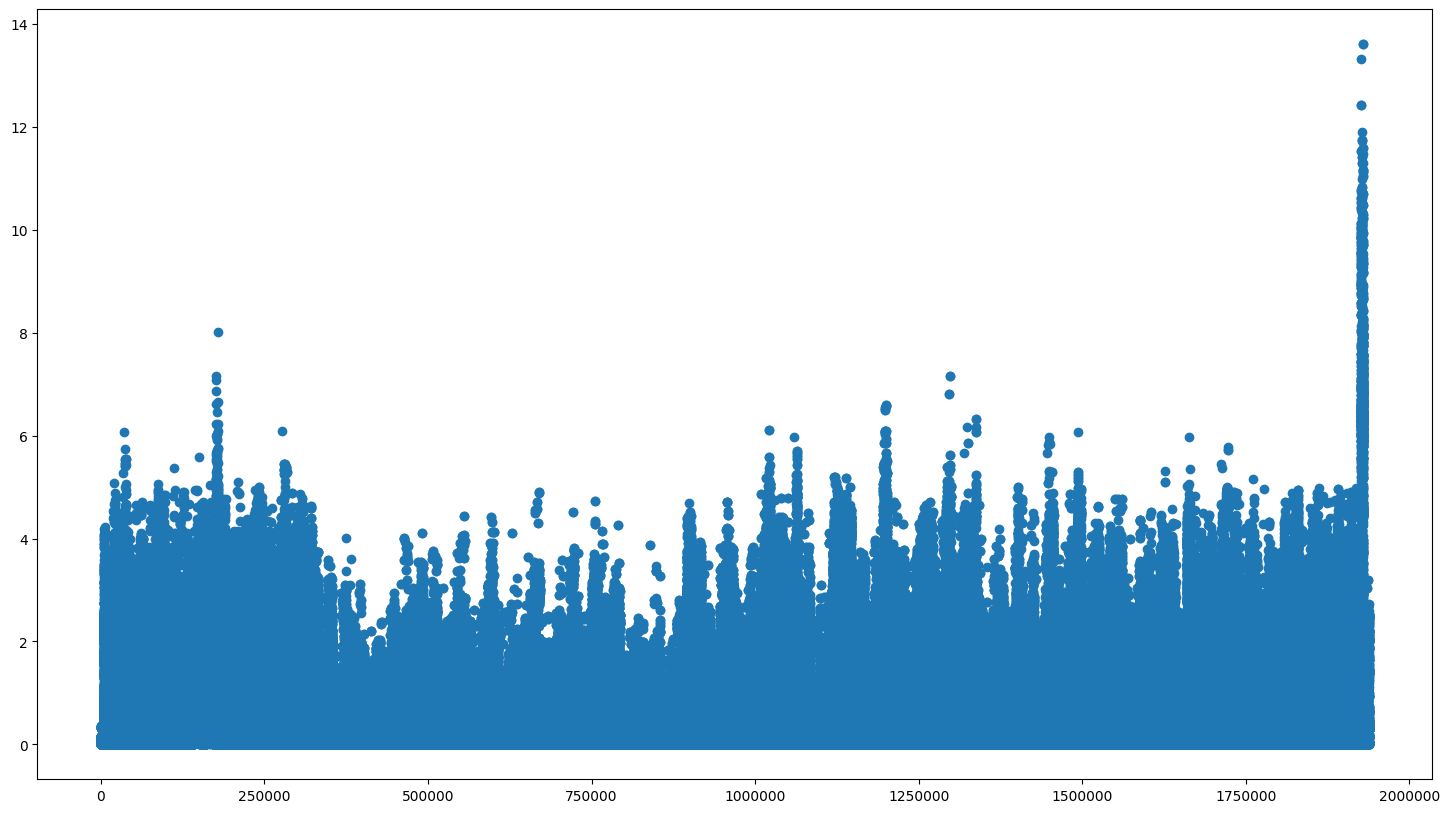

In [30]:
plt.figure(figsize=(18, 10))
# data['Load_kW'].plot()
plt.scatter(data.index, data['Load_kW'])  # Use data.index for x-axis
plt.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on the x-axis
plt.show()

In [11]:
df1 = data.loc[~data['location_id'].isin(location_lst)]
df1.reset_index(inplace=True)
df1

,creation_time,location_id,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
0,2024-07-01 00:00:00,100000020805,243.1000,246.2000,240.9000,0.0000,0.0000,0.2600,1.0000,1.0000,1.0000,0.0700
1,2024-07-01 00:00:00,100000031104,243.8000,247.0000,241.5000,0.2600,1.6100,0.7000,1.0000,0.9900,0.7300,0.6400
2,2024-07-01 00:00:00,100000040406,243.0000,247.1000,242.5000,0.2200,0.0000,1.4400,1.0000,1.0000,1.0000,0.4500
3,2024-07-01 00:00:03,100000020806,243.0000,246.7000,240.8000,0.0000,6.6500,0.0000,1.0000,1.0000,1.0000,1.6400
4,2024-07-01 00:00:03,100000031105,243.6000,246.7000,242.0000,0.1000,0.2600,2.1900,0.8000,0.6700,1.0000,0.6400
...,...,...,...,...,...,...,...,...,...,...,...,...
1618446,2024-07-31 23:59:53,100000020006,248.4000,250.8000,249.1000,0.0000,0.0000,0.5800,1.0000,1.0000,0.9700,0.1400
1618447,2024-07-31 23:59:53,100000030505,249.5000,250.2000,249.0000,0.2000,0.0800,6.3900,0.9800,1.0000,0.9900,1.6600
1618448,2024-07-31 23:59:55,100000041205,248.3000,251.5000,247.8000,0.0000,0.2900,2.0800,1.0000,0.6700,0.9300,0.5200
1618449,2024-07-31 23:59:56,100000030506,249.8000,249.8000,249.5000,0.8900,2.2600,0.0000,0.9900,0.9600,1.0000,0.9900


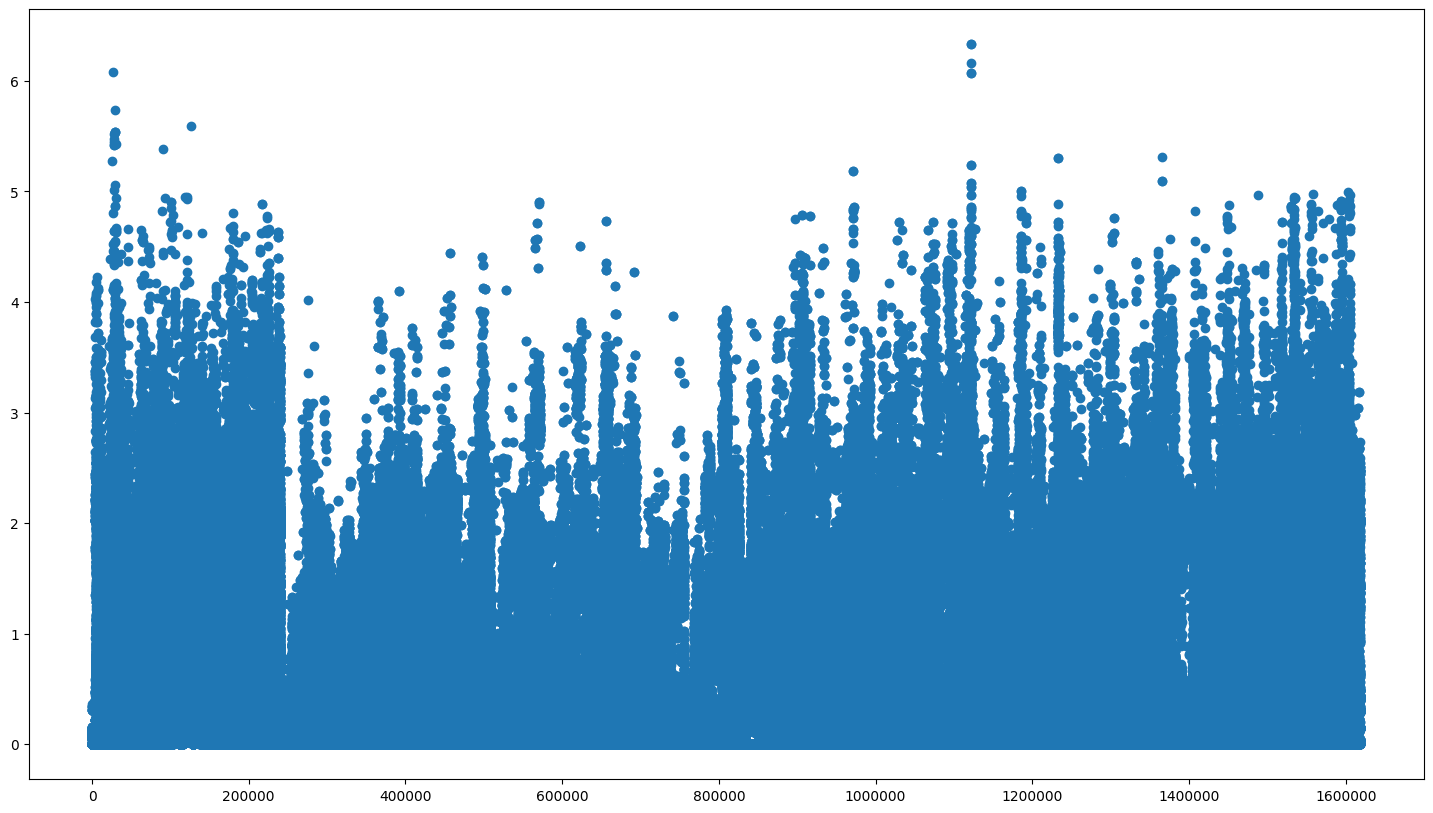

In [32]:
df1.reset_index(drop=True,inplace=True)
plt.figure(figsize=(18, 10))
# data['Load_kW'].plot()
plt.scatter(df1.index, df1['Load_kW'])  # Use data.index for x-axis
plt.ticklabel_format(style='plain', axis='x')  # Disable scientific notation on the x-axis
plt.show()

In [36]:
Q1 = load_df['Load_kW'].quantile(0.25)
Q3 = load_df['Load_kW'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define outliers as points outside 1.5 * IQR from Q1 and Q3
# lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)

1.6240154452961626


In [33]:
load_df['IQR'] = 


,Load_kW
location_id,
100000010001,0.1179
100000010002,0.9339
100000010003,0.5590
100000010004,0.0120
100000010101,1.3267
...,...
100000041404,0.7375
100000050306,0.9400
100000190001,3.3049


In [3]:
grouped_df = data.groupby('location_id')
for id,data in grouped_df:
    
    print(id,len(data))

100000010001 4411
100000010002 4234
100000010003 4274
100000010004 4474
100000010101 4026
100000010103 4409
100000010104 4218
100000010105 4245
100000010106 4286
100000010201 4212
100000010203 4390
100000010204 4278
100000010205 4388
100000010206 4464
100000010301 3823
100000010302 4293
100000010304 4373
100000010305 4383
100000010306 4428
100000010401 4371
100000010402 4373
100000010403 4441
100000010404 4309
100000010406 4250
100000010501 4426
100000010502 4220
100000010503 4307
100000010504 4389
100000010505 4321
100000010506 4362
100000010601 4045
100000010602 4308
100000010603 4367
100000010604 4230
100000010605 4258
100000010701 4344
100000010702 4323
100000010703 4224
100000010704 4257
100000010705 4183
100000010706 4341
100000010801 4082
100000010802 4218
100000010803 4325
100000010804 4253
100000010805 4320
100000010806 4255
100000010901 4350
100000010902 4275
100000010903 4027
100000010904 4354
100000010905 4361
100000010906 4383
100000011001 4331
100000011002 4272
1000000110

In [51]:
outlier_df = data.loc[data['location_id'].isin(location_lst)]
for d1 in 

,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
18923,100000010101,2024-07-12 23:56:04,246.2000,248.8000,245.9000,1.4500,5.6200,10.1800,1.0000,0.9900,1.0000,4.4000
18924,100000010101,2024-07-13 00:05:36,247.0000,250.1000,247.4000,1.9100,5.7500,10.0900,0.9900,0.9900,0.9900,4.5300
19274,100000010101,2024-07-15 14:21:28,231.5000,233.8000,232.5000,4.3400,7.9000,4.5400,1.0000,0.9900,0.9900,4.0600
19761,100000010101,2024-07-19 11:42:57,237.3000,239.0000,238.3000,4.1200,1.1200,11.5200,1.0000,0.9800,1.0000,4.1100
20043,100000010101,2024-07-21 14:20:47,239.8000,241.0000,241.2000,1.8700,5.3900,11.3500,0.9900,1.0000,1.0000,4.6700
...,...,...,...,...,...,...,...,...,...,...,...,...
1948507,100000190001,2024-07-31 18:53:29,249.4000,252.0000,250.4000,12.8200,8.7100,6.5600,0.9900,0.9500,0.7300,6.1300
1948508,100000190001,2024-07-31 19:02:50,253.2000,256.3000,254.8000,12.0700,6.7500,9.9200,0.9800,0.8700,0.8500,6.2900
1948509,100000190001,2024-07-31 19:12:14,259.5000,262.3000,261.1000,11.4200,8.2800,6.5100,0.9700,0.8900,0.6300,5.9000
1948510,100000190001,2024-07-31 19:22:14,259.5000,262.3000,261.1000,11.4200,8.2800,6.5100,0.9700,0.8900,0.6300,5.9000


In [52]:
data.columns

Index(['location_id', 'creation_time', 'R_Voltage', 'Y_Voltage', 'B_Voltage',
       'R_Current', 'Y_Current', 'B_Current', 'R_PF', 'Y_PF', 'B_PF',
       'Load_kW'],
      dtype='object')

In [5]:
load_df = data.loc[
    (data['Load_kW'] ==0)&
    # ((data['R_Voltage'] !=0) | (data['Y_Voltage']!=0) | (data['B_Voltage']!=0)) 
    ((data['R_Current']!=0) |  (data['Y_Current']!=0) | (data['B_Current']!=0))
         ]
# [['R_Current', 'Y_Current', 'B_Current']].plot()
# [['R_Voltage', 'Y_Voltage','B_Voltage','R_Current', 'Y_Current', 'B_Current', 'R_PF', 'Y_PF', 'B_PF','Load_kW']]
load_df

,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
27,100000010001,2024-07-01 05:01:28,254.3000,257.0000,254.5000,0.0000,0.4400,0.0000,1.0000,1.0000,1.0000,0.0000
28,100000010001,2024-07-01 05:10:53,254.3000,257.0000,254.5000,0.0000,0.4400,0.0000,1.0000,1.0000,1.0000,0.0000
173,100000010001,2024-07-02 05:11:10,251.9000,254.8000,252.6000,0.0000,0.4500,0.0000,1.0000,0.9900,1.0000,0.0000
191,100000010001,2024-07-02 08:33:28,250.6000,254.3000,251.6000,0.0000,0.4700,0.0000,1.0000,1.0000,1.0000,0.0000
227,100000010001,2024-07-02 14:19:20,233.9000,237.1000,234.4000,0.0000,0.4800,0.0000,1.0000,0.9900,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1935448,100000041403,2024-07-28 10:04:20,243.6000,244.2000,243.5000,0.0000,0.0200,0.1000,1.0000,0.4500,0.2400,0.0000
1940396,100000050306,2024-07-01 22:11:35,234.8000,235.0000,233.7000,0.2700,0.2300,3.3500,0.8600,0.9800,0.9900,0.0000
1952659,100000190011,2024-07-29 20:15:09,239.1000,242.6000,242.7000,0.0000,1.8900,0.0000,1.0000,0.9400,1.0000,0.0000
1952780,100000190011,2024-07-30 17:57:26,242.3000,245.0000,244.6000,0.0000,13.3500,0.0000,1.0000,0.9800,1.0000,0.0000


In [89]:
data[data['location_id']==100000010506].loc[data[data['location_id']==100000010506]['creation_time']=="2024-07-11 05:50:41"]

,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
126450,100000010506,2024-07-11 05:50:41,255.0000,257.5000,255.4000,0.7500,9.2800,12.3500,0.9900,0.9900,0.8900,0.0000


In [93]:


# Target location_id and specific timedd
target_location_id = 100000010506
target_time = pd.to_datetime("2024-07-11 05:50:41")

# Filter the data for that location_id and within the same hour as target_time
filtered_data = data[(data['location_id'] == target_location_id) & 
                     (data['creation_time'].dt.date == target_time.date()) &
                     (data['creation_time'].dt.hour >= target_time.hour)]

# Display the filtered data
filtered_data.head(20)


,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
126445,100000010506,2024-07-11 05:01:44,255.3000,258.5000,255.8000,0.2900,0.2700,1.7500,0.7600,0.9700,0.9100,0.5400
126446,100000010506,2024-07-11 05:11:37,255.2000,258.6000,256.1000,0.2900,0.2700,0.3400,0.7600,0.9800,0.8600,0.2100
126447,100000010506,2024-07-11 05:21:18,255.4000,258.8000,256.0000,0.2900,0.2700,0.3200,0.7700,1.0000,0.8400,0.2000
126448,100000010506,2024-07-11 05:31:04,255.0000,257.7000,255.9000,0.7400,0.2700,0.2200,0.9800,1.0000,0.3700,0.3000
126449,100000010506,2024-07-11 05:40:58,255.6000,258.4000,256.2000,0.7500,0.3200,0.2200,0.9900,0.9700,0.3800,0.3200
126450,100000010506,2024-07-11 05:50:41,255.0000,257.5000,255.4000,0.7500,9.2800,12.3500,0.9900,0.9900,0.8900,0.0000
126451,100000010506,2024-07-11 06:00:34,254.7000,258.9000,256.3000,0.8700,0.0800,0.2100,0.9900,0.9000,0.3600,0.2900
126452,100000010506,2024-07-11 06:10:18,254.2000,258.4000,255.8000,1.1300,0.3900,0.9700,0.9300,0.9900,0.9900,0.6200
126453,100000010506,2024-07-11 06:20:03,254.2000,258.4000,255.8000,1.1300,0.3900,0.9700,0.9300,0.9900,0.9900,0.6200
126454,100000010506,2024-07-11 06:29:41,254.8000,258.1000,255.8000,0.1400,0.3500,1.0000,0.8300,0.9900,1.0000,0.3900


In [85]:
load_df[load_df['location_id']==100000010506]

,location_id,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
126450,100000010506,2024-07-11 05:50:41,255.0000,257.5000,255.4000,0.7500,9.2800,12.3500,0.9900,0.9900,0.8900,0.0000
126923,100000010506,2024-07-14 15:39:21,246.1000,249.2000,247.0000,0.5600,0.0300,0.2700,0.7100,1.0000,0.4800,0.0000
127654,100000010506,2024-07-19 19:51:23,241.4000,243.3000,240.7000,0.5400,0.2400,0.2900,0.8000,0.9800,0.5200,0.0000


In [84]:
load_df.groupby('location_id').count().head(60)

,creation_time,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
location_id,,,,,,,,,,,
100000010001,51,51,51,51,51,51,51,51,51,51,51
100000010002,1,1,1,1,1,1,1,1,1,1,1
100000010004,1,1,1,1,1,1,1,1,1,1,1
100000010101,1,1,1,1,1,1,1,1,1,1,1
100000010106,1,1,1,1,1,1,1,1,1,1,1
100000010201,11,11,11,11,11,11,11,11,11,11,11
100000010205,27,27,27,27,27,27,27,27,27,27,27
100000010301,1,1,1,1,1,1,1,1,1,1,1
100000010304,1,1,1,1,1,1,1,1,1,1,1
